### Model assessment
Here we compared the weights learned by several model iterations, to highlight
- Performance user parameter combinations
- Interpretation based on TF regulators
- Coherence or learned graph-weights when assisting RNA-weights, or only using ATAC-weights

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
!readlink -f .

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


In [6]:
import torch
import mubind as mb
import scanpy as sc

In [7]:
!ls -ltrh /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022*

-rw-rw-r-- 1 ilibarra ilibarra  18M Jun 10 02:06 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_use_logdynamic_0.pth
-rw-rw-r-- 1 ilibarra ilibarra  21M Jun 10 02:06 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_use_logdynamic_1.pth
-rw-rw-r-- 1 ilibarra ilibarra 909M Jun 10 02:06 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_sample_train.h5ad
-rw-rw-r-- 1 ilibarra ilibarra  18M Jun 13 02:51 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_use_logdynamic_0_obs7468.pth
-rw-rw-r-- 1 ilibarra ilibarra  21M Jun 13 02:51 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_use_logdynamic_1_obs7468.pth
-rw-rw-r-- 1 ilibarra ilibarra 887M Jun 13 02:51 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/noack_2022_sample_train_obs7468.h5ad
-rw-rw-r-- 1 ilibarra ilibarra 833K Jul  5 00:27 /home/ilibarra/workspace/theislab/mubin

In [8]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [9]:
# query
# obs_id = 7468 # publication case
obs_id = 7359 # testing hadamard
# 7359
import os
# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = 'noack_2022_use_logdynamic_%i_obs%s.pth' % (use_logdynamic, obs_id)
    print(os.path.exists(p), p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

True noack_2022_use_logdynamic_0_obs7359.pth
True noack_2022_use_logdynamic_1_obs7359.pth


In [10]:
ad = sc.read_h5ad('noack_2022_sample_train_obs%s.h5ad' % obs_id)
# ad = sc.read_h5ad('atac_train.h5ad')
#rna_sample = sc.read_h5ad('rna_sample_train.h5ad')
rna_sample = ad

In [11]:
rna_sample.shape

(7359, 1948)

In [12]:
import pickle
train = pickle.load(open('train_dataloader_obs%s.pkl' % obs_id, 'rb'))

In [13]:
%load_ext line_profiler

In [14]:
# # load the pancreas multiome dataset
# rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')


In [15]:
# %lprun -f model.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [16]:
# %lprun -f model.binding_modes.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [17]:
import matplotlib.pyplot as plt

False
break


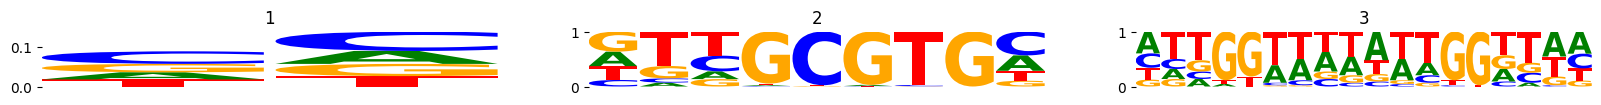

True
break


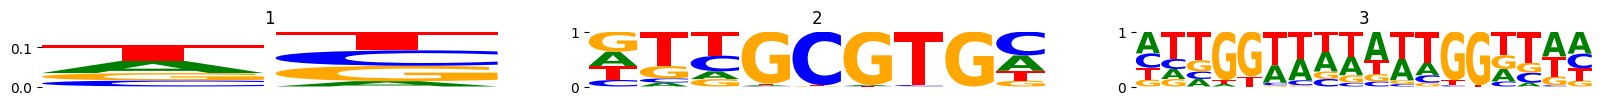

In [18]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=4) #  log=True)
    plt.show()


True


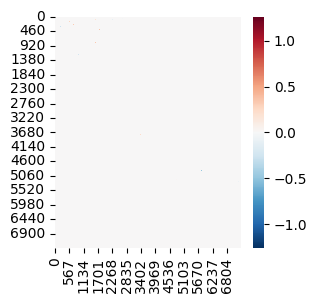

In [19]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

In [20]:
model = model_by_logdynamic[1]

In [21]:
D

tensor(indices=tensor([[   0,    0,    0,  ..., 6906, 6980, 7289],
                       [   1,  251,  289,  ..., 7358, 7358, 7358]]),
       values=tensor([ 0.1255,  0.5133,  0.5014,  ..., -0.5014, -0.5014,
                      -0.5014]),
       device='cuda:0', size=(7359, 7359), nnz=280548, layout=torch.sparse_coo,
       grad_fn=<AddBackward0>)

In [22]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

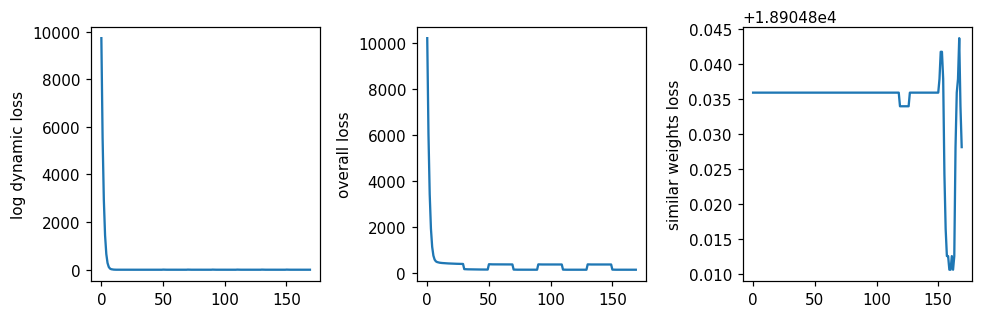

In [23]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')
plt.tight_layout()

plt.savefig('losses_noack.pdf')
plt.show()

In [24]:
!readlink -f losses.pdf

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/losses.pdf


In [25]:
import pandas as pd
import numpy as np

False
True


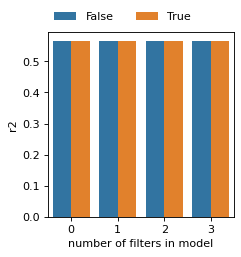

In [26]:
rcParams['figure.figsize'] = 3, 5
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams['figure.figsize'] = 3, 3
    rcParams['figure.dpi'] = 80
    ax = sns.barplot(data=r2_all, x='index', y='r2', hue='opt_log_dynamic', )
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.4, 1), ncol=3, title=None, frameon=False)

    plt.xlabel('number of filters in model')
    plt.show()

   index        r2  opt_log_dynamic
3      3  0.566473            False
3      3  0.564373             True


<Axes: xlabel='opt_log_dynamic', ylabel='r2'>

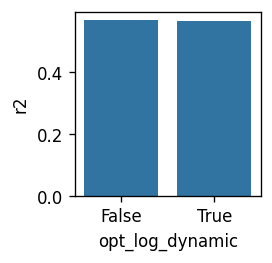

In [27]:
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = 2, 2
df = r2_all.sort_values('index', ascending=False).groupby('opt_log_dynamic').head(1)
print(df)
sns.barplot(df, y='r2', x='opt_log_dynamic')

In [28]:

model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2


In [29]:
ad.obs['dynamic_score'].describe()

count    7359.000000
mean        0.438135
std         0.054474
min         0.000000
25%         0.438130
50%         0.438135
75%         0.438140
max         1.000000
Name: dynamic_score, dtype: float64

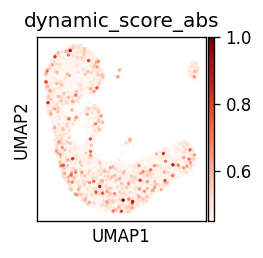

In [30]:
ad.obs['dynamic_score_abs'] = ad.obs['dynamic_score'].abs()
sc.pl.umap(ad, color='dynamic_score_abs', color_map='Reds', vmin=.45)

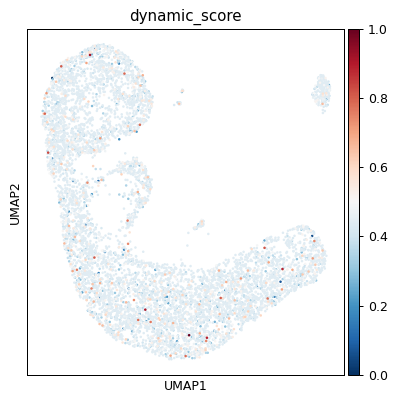

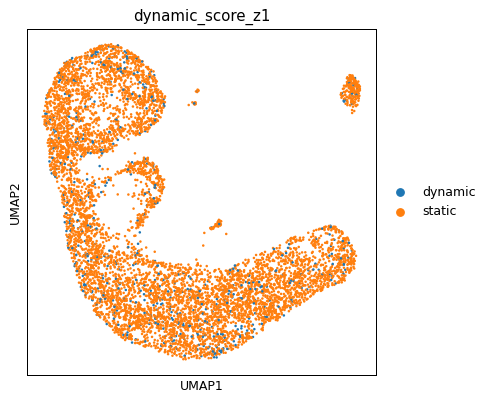

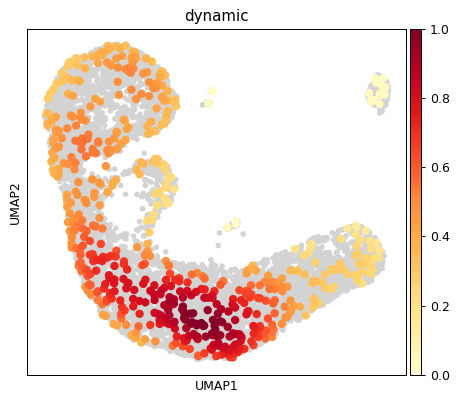

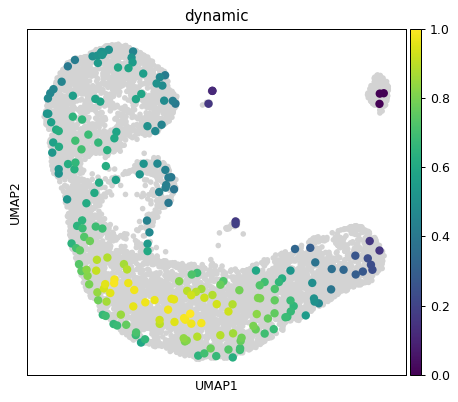

In [31]:


# contributions per newly added kernel
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic', color_map='viridis') # basis='umap', groupby='dynamic_score_cluster')

<Axes: >

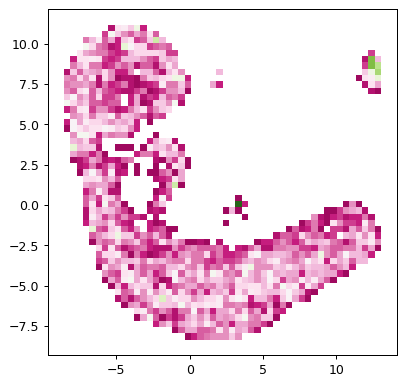

In [32]:
import seaborn as sns
umap = ad.obsm['X_umap']
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap='PiYG')

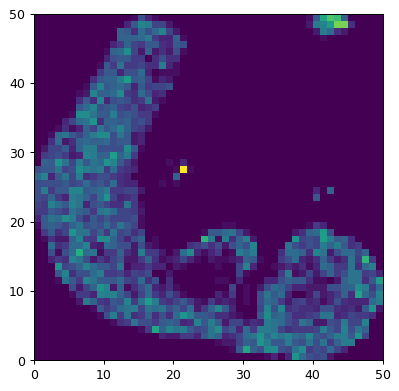

In [33]:
plt.pcolormesh(
    np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0]
)

In [34]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [35]:
x = umap[:,1] # array_txt[:,0]
y = umap[:,1] # array_txt[:,1]
z = ad.obs['dynamic_score'].values # array_txt[:,2]


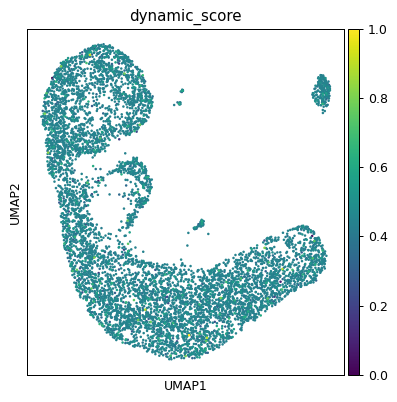

In [36]:
sc.pl.umap(ad, color='dynamic_score')

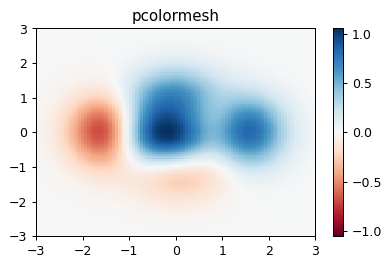

In [37]:
import matplotlib.pyplot as plt
import numpy as np
rcParams['figure.figsize'] = 5, 3

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [38]:
import itertools
import numpy as np

def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)


In [39]:
cell_type_key = 'clusters'

In [40]:
grid_dyn_score = grid(umap[:,0], umap[:,1], ad.obs['dynamic_score'], size_x=1, size_y=1)
grid_counts = grid(umap[:,0], umap[:,1], ad.obs[cell_type_key].cat.codes.values, size_x=1, size_y=1)

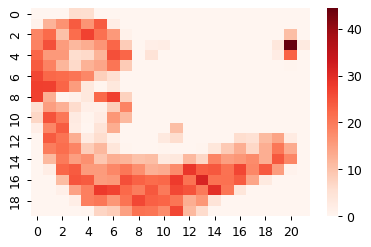

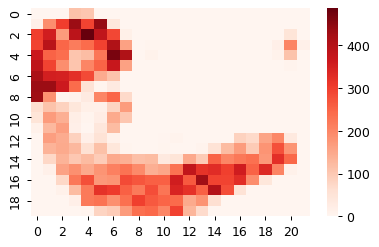

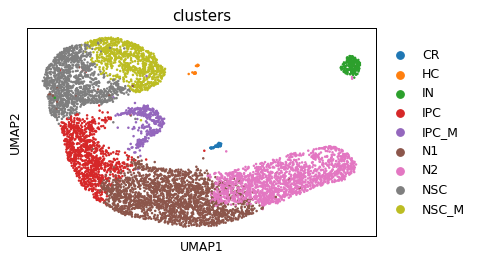

In [41]:

sns.heatmap(grid_dyn_score, cmap='Reds')
plt.show()
sns.heatmap(grid_counts, cmap='Reds')
plt.show()

sc.pl.umap(ad, color=cell_type_key)

In [42]:
# for optimize_log_dynamic in model_by_logdynamic:
#     mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
#     print(optimize_log_dynamic)
#     model = model_by_logdynamic[optimize_log_dynamic]
#     mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
#     plt.show()

#     mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
#     mb.pl.logo(model,
#                title=False,
#                xticks=False,
#                rowspan_dinuc=0,
#                rowspan_mono=1,
#                n_rows=12,
#                n_cols=3,
#                stop_at=20) # n_cols=len(reduced_groups))
#     plt.show()


In [43]:
model = model_by_logdynamic[True]

In [44]:
G = model.graph_module.conn_sparse.detach().cpu().to_dense() # (C, C)

In [45]:
# number of non_zero weights
len(G[G != 0])

140274

In [46]:
# output = model(**inputs, use_conn=False, return_binding_scores=True)

In [47]:
print('here...')

here...


In [48]:
ad

AnnData object with n_obs × n_vars = 7359 × 1948
    obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'louvain', 'clusters', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling', 'chrom', 'pos', 'strand', 'tss_start', 'tss_end', 'chromosome_name', 'k', 'acc_score', 'acc_score_rank', 'chr', 'summit.start', 'summit.end', 'k.summit'
    uns: 'clusters_colors', 'louvain', 'lo

In [49]:
model = model.cuda()

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
# device

In [51]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [52]:
train.batch_size

256

In [53]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic].cuda()    
    umap = ad.obsm['X_umap'].copy()
    umap = np.sort(umap, 0)

    x = umap[:,0]
    y = umap[:,1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                      "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs['scale_countsum'] = model.datatype == 'selex'

        
        output = model(**inputs, use_conn=False, return_binding_scores=True)

        output = output.cpu().detach().numpy()
        print('here...')
        print(output.shape)

        print(output.sum())
        pred.append(output)

    # pred = np.concatenate(pred).T

    binding_scores = np.concatenate(pred).T


    # ad.layers['velocity'] = pred
    
    # conn = model.graph_module.conn_sparse.detach().cpu()
    # conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
    # v = conn.sum(axis=1)
    # ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()
    
    # ad.layers['counts'] = ad.X

    # mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    # plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    # plt.show()

    # import scvelo as scv

    # sc.pp.neighbors(ad)

    # # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # # ad.layers['velocity'] = ad.obs['dynamic_score']
    
    # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)


X = ad.X.A
G @ binding_scores
np.random.shuffle(binding_scores)

False
True
here...
(256, 7359)
4055290300000.0
here...
(256, 7359)
6317207000000.0
here...
(256, 7359)
5242914000000.0
here...
(256, 7359)
4033818400000.0
here...
(256, 7359)
4542154400000.0
here...
(256, 7359)
3474303200000.0
here...
(256, 7359)
5099480400000.0
here...
(156, 7359)
3765126000000.0


In [54]:
import scvelo as scv

In [55]:
ad.shape, binding_scores.shape

((7359, 1948), (7359, 1948))

In [56]:
ad
ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

In [57]:
np.random.shuffle(binding_scores)
binding_scores

array([[1742439. , 1966243.4, 1944581.6, ..., 2549281.2, 3346296. ,
        2905771. ],
       [1742382.1, 1966200.1, 1944551.4, ..., 2549803. , 3347279.8,
        2906606.5],
       [1742469.6, 1966290.5, 1944630.9, ..., 2549936.2, 3347304.5,
        2906533. ],
       ...,
       [1742390.1, 1966195.9, 1944579. , ..., 2550213. , 3347730.2,
        2906630.8],
       [1742391.9, 1966217.2, 1944551.1, ..., 2550047. , 3347594.2,
        2906810.8],
       [1742527.1, 1966385.2, 1944695.5, ..., 2549845.2, 3347059. ,
        2905971. ]], dtype=float32)

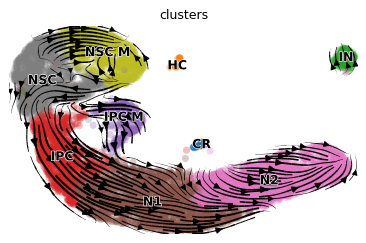

In [58]:
try:
    scv.pl.velocity_embedding_stream(rna_sample, color=cell_type_key)
except Exception:
    print("sample too small.")

In [59]:
# np.random.shuffle(binding_scores)
# ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

In [60]:
# model_by_log

In [61]:
import seaborn as sns
act_on = model_by_logdynamic[True].get_log_activities().detach().cpu().squeeze(0)
act_off = model_by_logdynamic[False].get_log_activities().detach().cpu().squeeze(0)


<Axes: >

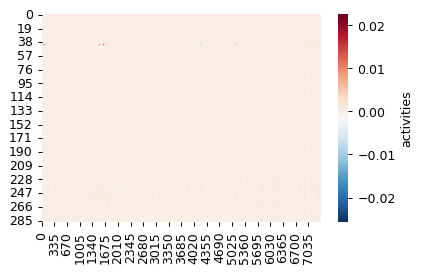

In [62]:
sns.heatmap(act_on, cmap='RdBu_r', cbar_kws={'label': 'activities'})

In [63]:
# # highlight the top-n filters per cell, with the top variability
# rcParams['figure.dpi'] = 100
# n_show = 15
# print(act.var(axis=1).sort()[1][-n_show:])
# act_sel = act[act.var(axis=1).sort()[1][-n_show:],:]
# vmax = act_sel.abs().max()
# sns.clustermap(act_sel,
#                vmin=-vmax / 2, vmax=vmax / 2,
#                cmap='RdBu_r',
               
#                cbar_kws={'label': 'activities'},
#                figsize=[5, 3])


In [64]:
# rna_sample.layers['velocity'].shape, rna_sample.shape

In [65]:
# scv.pl.velocity_graph(rna_sample)

In [66]:

# ax = scv.pl.velocity_embedding_stream(ad,
#                                       color='celltype',
#                                       # density=2,
#                                       arrow_color='black',
#                                       n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [67]:
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', density=2, arrow_color='black', n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [68]:
# scv.pl.velocity_embedding_stream(ad, color='celltype', n_neighbors=15) #  X_grid='X_umap', V=V)

## Study the asssociations betweeen obtained weights and cluster-specific transcription factors

Load information from archetypes DB (Vierstra et al 2020)

In [69]:
rna_sample, ad.shape

(AnnData object with n_obs × n_vars = 7359 × 1948
     obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'louvain', 'clusters', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling', 'chrom', 'pos', 'strand', 'tss_start', 'tss_end', 'chromosome_name', 'k', 'acc_score', 'acc_score_rank', 'chr', 'summit.start', 'summit.end', 'k.summit'
     uns: 'clusters_colors', 'louvain',

In [70]:
rna_sel = rna_sample # rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape

(7359, 1948)

In [71]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [72]:
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'

anno = mb.datasets.archetypes_anno()

In [73]:
rna_sel.shape
anno.sort_values('Cluster_ID')

Cluster_ID          Name          DBD             Seed_motif  \
61            1          HD/1  homeodomain     LHX6_homeodomain_3   
72            2          HD/2  homeodomain          ALX3_MA0634.1   
79            3          HD/3  homeodomain    VENTX_homeodomain_2   
80            4          HD/4  homeodomain  BARX1_MOUSE.H11MO.0.C   
81            5          HD/5  homeodomain    BARX1_homeodomain_1   
..          ...           ...          ...                    ...   
163         282         PAX/2          PAX   PAX5_HUMAN.H11MO.0.A   
161         283  PAX-halfsite          PAX          Pax2_MA0067.1   
0           284           AHR         bHLH    AHR_HUMAN.H11MO.0.B   
105         285      KLF/SP/3         C2H2   KLF8_HUMAN.H11MO.0.C   
285         286        ZSCAN4         C2H2          ZSCAN4_C2H2_1   

     Total_width  Consensus_left  Consensus_right  Cluster_size  
61            12               0               12             2  
72            26               8               16           186  
79            21               3               20             1  
80            17               5               13            17  
81            21               2               18             6  
..           ...             ...              ...           ...  
163           24               4               21             3  
161            8               1                7             1  
0              9               2                8             3  
105            9               0                9             2  
285           15               1               14             2  

[286 rows x 8 columns]

In [74]:
print('here...')

here...


False


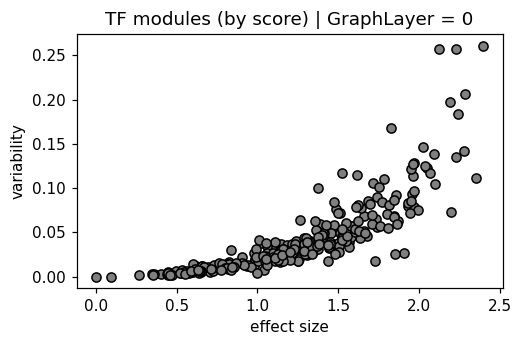

True


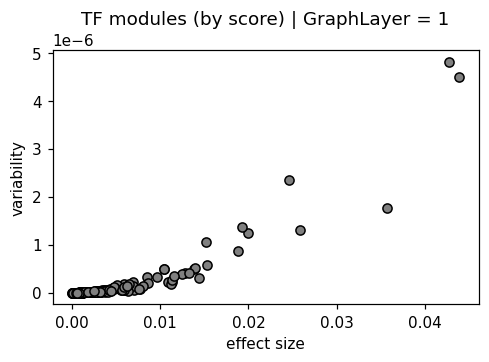

In [75]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 110})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var, color='gray', edgecolors='black')
    plt.xlabel('effect size')
    plt.ylabel('variability')
    plt.title('TF modules (by score) | GraphLayer = %i' % optimize_log_dynamic )
    plt.show()

In [76]:
# unique names for annotation
names = anno['Name'] # .sort_values('Name')
added = dict()
new_name = []
for name in names:
    if not name in added:
        new_name.append(name)
        added[name] = 0
    else:
        new_name.append(name + '_%i' % added[name])
        added[name] += 1
anno['Name_unique'] = new_name


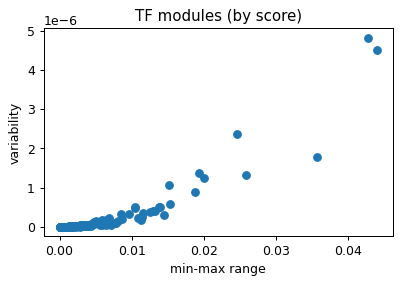

In [77]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        # print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])



In [78]:

# add archetypes name
meta = pd.DataFrame(pd.concat([delta, var], axis=1))
meta.columns = ['max_effect', 'variability']
meta['name'] = ['intercept', 'dinuc_bias'] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
meta['archetypes_name'] = meta['name'].map(anno.set_index('Cluster_ID')['Name_unique'])
meta['archetypes_name'] = np.where(pd.isnull(meta['archetypes_name']), meta['name'], meta['archetypes_name'])

meta['archetypes_seed'] = meta['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])

meta['filter_position'] = range(0, meta.shape[0])

In [79]:
meta = meta.sort_values('max_effect', ascending=0)
meta

res = res.merge(meta, left_on='archetype_id', right_on='name')
res = res.sort_values('p_val', ascending=True)

In [80]:
name_by_filter_id = meta['archetypes_name'].to_dict()
# name_by_filter_id

## Observe general scores per case

In [81]:
res

opt_log_dynamic archetype_id  spearman         p_val  max_effect  \
103             True          102  0.139282  3.355112e-33    0.003247   
126             True          125  0.138437  8.133633e-33    0.001896   
166             True          165 -0.134058  7.351971e-31    0.003608   
18              True           17 -0.129317  8.166232e-29    0.005969   
63              True           62  0.124271  1.015061e-26    0.000796   
..               ...          ...       ...           ...         ...   
181             True          180  0.003626  7.557977e-01    0.002967   
177             True          176  0.003364  7.729420e-01    0.000338   
133             True          132 -0.001165  9.203964e-01    0.001180   
170             True          169 -0.000909  9.378249e-01    0.003005   
51              True           50  0.000594  9.594010e-01    0.001429   

      variability name archetypes_name        archetypes_seed  filter_position  
103  2.366894e-08  102          NFAT/3          NFATC1_NFAT_2              103  
126  6.688103e-09  125         SMARCA5  SMCA5_HUMAN.H11MO.0.C              126  
166  2.721062e-08  165            RBPJ          RBPJ_MA1116.1              166  
18   6.380463e-08   17           CUX/4   CUX2_MOUSE.H11MO.0.C               18  
63   1.534651e-09   62     Ebox/CATATG     Atoh1.mouse_bHLH_1               63  
..            ...  ...             ...                    ...              ...  
181  2.802784e-08  180           SIX/1   SIX1_HUMAN.H11MO.0.A              181  
177  8.948248e-11  176          PRDM16  PRD16_MOUSE.H11MO.0.B              177  
133  2.442504e-09  132           THAP1         THAP1_MA0597.1              133  
170  1.881324e-08  169          BCL6/1           BCL6B_C2H2_1              170  
51   7.456526e-09   50      CREB/ATF/2          ATF7_MA0834.1               51  

[288 rows x 10 columns]

<Axes: xlabel='max_effect', ylabel='archetypes_name'>

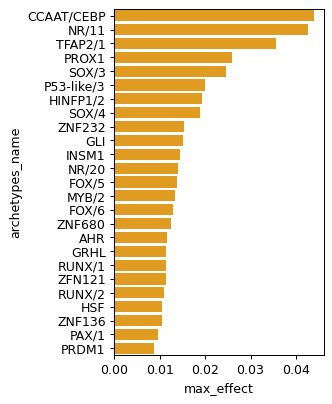

In [82]:
rcParams['figure.figsize'] =3, 5
sns.barplot(data=res.sort_values('max_effect', ascending=False).head(25), x='max_effect', y='archetypes_name', color='orange')

In [83]:
res

opt_log_dynamic archetype_id  spearman         p_val  max_effect  \
103             True          102  0.139282  3.355112e-33    0.003247   
126             True          125  0.138437  8.133633e-33    0.001896   
166             True          165 -0.134058  7.351971e-31    0.003608   
18              True           17 -0.129317  8.166232e-29    0.005969   
63              True           62  0.124271  1.015061e-26    0.000796   
..               ...          ...       ...           ...         ...   
181             True          180  0.003626  7.557977e-01    0.002967   
177             True          176  0.003364  7.729420e-01    0.000338   
133             True          132 -0.001165  9.203964e-01    0.001180   
170             True          169 -0.000909  9.378249e-01    0.003005   
51              True           50  0.000594  9.594010e-01    0.001429   

      variability name archetypes_name        archetypes_seed  filter_position  
103  2.366894e-08  102          NFAT/3          NFATC1_NFAT_2              103  
126  6.688103e-09  125         SMARCA5  SMCA5_HUMAN.H11MO.0.C              126  
166  2.721062e-08  165            RBPJ          RBPJ_MA1116.1              166  
18   6.380463e-08   17           CUX/4   CUX2_MOUSE.H11MO.0.C               18  
63   1.534651e-09   62     Ebox/CATATG     Atoh1.mouse_bHLH_1               63  
..            ...  ...             ...                    ...              ...  
181  2.802784e-08  180           SIX/1   SIX1_HUMAN.H11MO.0.A              181  
177  8.948248e-11  176          PRDM16  PRD16_MOUSE.H11MO.0.B              177  
133  2.442504e-09  132           THAP1         THAP1_MA0597.1              133  
170  1.881324e-08  169          BCL6/1           BCL6B_C2H2_1              170  
51   7.456526e-09   50      CREB/ATF/2          ATF7_MA0834.1               51  

[288 rows x 10 columns]

break


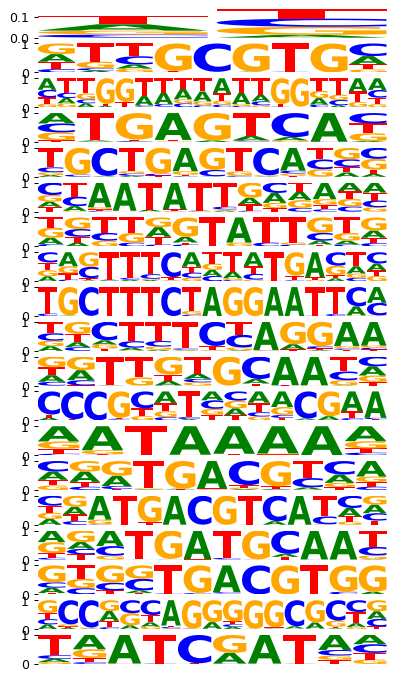

In [84]:
# visualize the logos as obtained by the model in each step
mb.pl.set_rcParams({'figure.figsize': [5, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
           # n_rows=len(res.head(20).index),

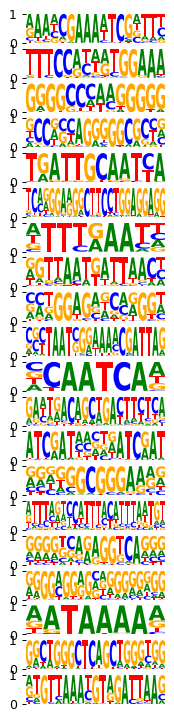

<Figure size 180x1800 with 0 Axes>

In [85]:
mb.pl.set_rcParams({'figure.figsize': [2, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40,
           # n_rows=len(res.head(20).index),
           n_cols=1, order=res.head(20).index) # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [86]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 6.952268


In [87]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [88]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [89]:
vars_mapper = {}
def find_varname(ad, k, shuffle=False, ):
    if not shuffle:
        if k in vars_mapper:
            return vars_mapper[k]
        else:
            result = ad.var_names[ad.var_names.str.upper().str.startswith(k.upper())]
            vars_mapper[k] = result
            return result
    else:
        ad_sel = ad.var_names[ad.var_names.str.upper().str.startswith(k.upper())]
        return pd.Series(ad.var_names).sample(ad_sel.shape[0]).values

In [90]:
from scipy.stats import spearmanr, pearsonr

Calculate global correlations between the activities obtained per motif and gene-specific expression

In [91]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')


False
True


In [92]:

def get_act_gene_corr(model_by_logdynamic, shuffle=False, random_state=0):
    print('association between motif activities and related TF targets (shuffle = %i)' % shuffle)
    res = []
    # print(len(all_targets))

    rna_sel_df = rna_sel.to_df()

    for optimize_log_dynamic in model_by_logdynamic:
        print('use GraphLayer = %i' % optimize_log_dynamic)
        model = model_by_logdynamic[optimize_log_dynamic]

        log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
        log_act = pd.DataFrame(log_act.detach().cpu().numpy())
        log_act.index = ad.obs_names

        ad.obsm['log_activities'] = log_act
        ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

        if shuffle:
            random_cols = ad.obsm['log_activities'].iloc[:,2:].columns.values
            np.random.shuffle(random_cols)
            # random_cols
        
        for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
            next_log_act = ad.obsm['log_activities'][k].values

            # if shuffle:
            #     next_log_act = ad.obsm['log_activities'][random_cols[ki]].values
            
            # print(ki)
            # if ki % 30 == 0:
            #     print(ki)
            names = set()
            clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
            for g in clu_sel:
                names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
            for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
                names.add(g.split('_')[0].split('.')[0])
            # print(k, names)
            next_targets = set()
            for name in names:
                target = find_varname(rna_sel, name, shuffle=shuffle)
                # print(name, target)
                for t in target:
                    next_targets.add(t)

            # for t in all_targets:
            for t in set(all_targets).intersection(next_targets):
                gex = rna_sel_df[[t]].to_numpy() # rna_sel_df[t].A
                assert gex.shape[1] == 1
                gex = gex.flatten()
                # print(next_log_act.shape, gex.shape)
                # print(t, pearsonr(next_log_act, gex))
                res.append([ki, optimize_log_dynamic, k, t, t in next_targets] +
                        list(spearmanr(next_log_act, gex)))
                
    res = pd.DataFrame(res, columns=['filter_id', 'opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

    # p-values
    res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
    res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])
    
    # p-val adjust
    from statsmodels.stats.multitest import fdrcorrection
    res['p_adj'] = fdrcorrection(res['p_val'])[1]
    return res


In [93]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [94]:
%lprun -f get_act_gene_corr get_act_gene_corr(model_by_logdynamic, shuffle=0)

association between motif activities and related TF targets (shuffle = 0)
use GraphLayer = 0
use GraphLayer = 1


Timer unit: 1e-09 s

Total time: 1.51881 s
File: /tmp/ipykernel_24341/1219755437.py
Function: get_act_gene_corr at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_act_gene_corr(model_by_logdynamic, shuffle=False, random_state=0):
     2         1     182188.0 182188.0      0.0      print('association between motif activities and related TF targets (shuffle = %i)' % shuffle)
     3         1        524.0    524.0      0.0      res = []
     4                                               # print(len(all_targets))
     5                                           
     6         1   24576172.0    2e+07      1.6      rna_sel_df = rna_sel.to_df()
     7                                           
     8         3       2161.0    720.3      0.0      for optimize_log_dynamic in model_by_logdynamic:
     9         2     122402.0  61201.0      0.0          print('use GraphLayer = %i' % optimize_log_dynamic)
    10   

In [95]:
res = get_act_gene_corr(model_by_logdynamic)
shuffled = [get_act_gene_corr(model_by_logdynamic, shuffle=1, random_state=i) for i in range(10)]

association between motif activities and related TF targets (shuffle = 0)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLa

In [96]:
table = []
for use_graph in [False, True]:
    for thr in range(1, 10):
        sel = res[res['opt_log_dynamic'] == use_graph]
        next_thr = 10 ** (-thr)
        n_pos = sel[sel['p_adj'] < next_thr].shape[0]
        n_neg = [s[(s['p_adj'] < next_thr) & (s['opt_log_dynamic'] == use_graph)].shape[0] for s in shuffled]
        # print(next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg))
        table.append([next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg), use_graph])
table = pd.DataFrame(table, columns=['p_adj_thr', 'n_pos', 'mu', 'sigma', 'zscore', 'graph_layer'])
table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore')

p_adj_thr    1.000000e-09  1.000000e-08  1.000000e-07  1.000000e-06  \
graph_layer                                                           
False           43.172477     42.862832     42.570044     42.494349   
True            18.032126     22.626105     20.713755     20.594524   

p_adj_thr    1.000000e-05  1.000000e-04  1.000000e-03  1.000000e-02  \
graph_layer                                                           
False           43.145921     43.046541     39.875000     39.599274   
True            22.479719     30.691892     36.402467     34.208363   

p_adj_thr    1.000000e-01  
graph_layer                
False           38.265423  
True            42.635843

Text(0.5, 1.0, 'associations between activity layer and TF (GEX)')

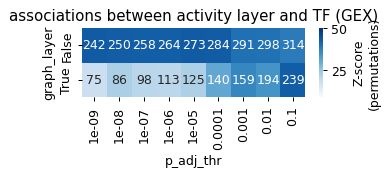

In [97]:
rcParams['figure.figsize'] = 4, 1
hm = table.pivot(index='graph_layer', columns='p_adj_thr', values='n_pos').fillna(0)
z = table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore').fillna(0)
sns.heatmap(z, annot=hm, fmt='', cmap='Blues', cbar_kws={'label': 'Z-score\n(permutations)'},
            vmin=9,
            vmax=50)
plt.title('associations between activity layer and TF (GEX)')

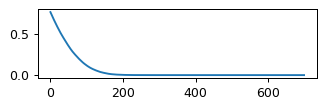

In [98]:
cumulative = np.cumsum(res.sort_values('p_adj')['p_adj']) / 100
plt.plot(range(len(cumulative)), cumulative[::-1])

In [99]:
shuffled[0].sort_values('p_val')

filter_id  opt_log_dynamic  archetype_id  gene_name  matched  spearman  \
2          95            False             8      Scrt1     True -0.448074   
34        257            False            54       Tpm4     True -0.413388   
22        216            False            70        Tk1     True -0.378365   
36        257            False            54       Zeb1     True -0.321987   
31        221            False            53  Arhgap11a     True -0.309905   
..        ...              ...           ...        ...      ...       ...   
13        195            False           248     Tubb2a     True -0.002399   
41         27             True           203      Glis2     True -0.002243   
67        196             True             2      Arnt2     True -0.001967   
62        173             True            32    Tspan11     True -0.001081   
53         91             True           273      Trim3     True -0.000737   

            p_val module_name          p_adj  
2    0.000000e+00        HD/8   0.000000e+00  
34  9.271101e-302       AP1/1  4.403773e-300  
22  3.646135e-249       TBX/1  1.154609e-247  
36  4.015730e-177       AP1/1  9.537358e-176  
31  1.477263e-163       AP1/2  2.806799e-162  
..            ...         ...            ...  
13   8.369483e-01       NR/20   8.737372e-01  
41   8.474755e-01       FOX/8   8.751106e-01  
67   8.660415e-01        HD/2   8.846660e-01  
62   9.261391e-01        NR/3   9.359916e-01  
53   9.495875e-01         ZIC   9.495875e-01  

[95 rows x 9 columns]

In [100]:
res.sort_values('p_adj')

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
349        280            False           281      Pax6     True -0.565214   
177         69            False            70    Tagln3     True -0.554236   
175         69            False            70      Ttc3     True -0.484895   
174         69            False            70    Tmsb4x     True -0.476951   
169         69            False            70     Ttyh1     True  0.522790   
..         ...              ...           ...       ...      ...       ...   
509         69             True            70     Tor1b     True  0.000547   
580         69             True            70  Tmem132c     True  0.000217   
77          57            False            58      Mitf     True  0.000195   
635        127             True           128      Nfia     True  0.000143   
518         69             True            70      Thrb     True  0.000102   

        p_val    module_name     p_adj  
349  0.000000          PAX/1  0.000000  
177  0.000000          TBX/1  0.000000  
175  0.000000          TBX/1  0.000000  
174  0.000000          TBX/1  0.000000  
169  0.000000          TBX/1  0.000000  
..        ...            ...       ...  
509  0.962586          TBX/1  0.968118  
580  0.985119          TBX/1  0.989359  
77   0.986676  Ebox/CACGTG/1  0.989504  
635  0.990214          NFI/3  0.991630  
518  0.993010          TBX/1  0.993010  

[700 rows x 9 columns]

In [101]:
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
# res[res['p_adj'] < 0.1]

In [102]:
genes_by_module_name = res.groupby(['module_name'])['gene_name'].apply(lambda grp: list(grp.value_counts().index)).to_dict()
# genes_by_module_name

In [103]:
res.sort_values('p_adj')

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
349        280            False           281      Pax6     True -0.565214   
177         69            False            70    Tagln3     True -0.554236   
175         69            False            70      Ttc3     True -0.484895   
174         69            False            70    Tmsb4x     True -0.476951   
169         69            False            70     Ttyh1     True  0.522790   
..         ...              ...           ...       ...      ...       ...   
509         69             True            70     Tor1b     True  0.000547   
580         69             True            70  Tmem132c     True  0.000217   
77          57            False            58      Mitf     True  0.000195   
635        127             True           128      Nfia     True  0.000143   
518         69             True            70      Thrb     True  0.000102   

        p_val    module_name     p_adj  
349  0.000000          PAX/1  0.000000  
177  0.000000          TBX/1  0.000000  
175  0.000000          TBX/1  0.000000  
174  0.000000          TBX/1  0.000000  
169  0.000000          TBX/1  0.000000  
..        ...            ...       ...  
509  0.962586          TBX/1  0.968118  
580  0.985119          TBX/1  0.989359  
77   0.986676  Ebox/CACGTG/1  0.989504  
635  0.990214          NFI/3  0.991630  
518  0.993010          TBX/1  0.993010  

[700 rows x 9 columns]

In [104]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot(index='k', columns='opt_log_dynamic', values='spearman')
# df2 = res # .pivot(index='k', columns='opt_log_dynamic', values='spearman')

In [105]:
df2

opt_log_dynamic     False     True 
k                                  
Arap2_248        0.050344  0.032765
Arfgef3_248      0.194122  0.083080
Arg2_248         0.174381  0.030984
Arhgap11a_248   -0.396027 -0.015390
Arhgap20_248     0.092057  0.035744
...                   ...       ...
Zeb1_68         -0.061055  0.016079
Zic1_110        -0.065828  0.019893
Zic1_273        -0.013335  0.005078
Zic2_273        -0.072651  0.022927
Zic4_273        -0.008062 -0.017463

[350 rows x 2 columns]

In [106]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
# df2 = df2.sort_values('matched', ascending=True)
# plt.scatter(df2[True], df2[True],
#             color=np.where(df2['matched'], 'blue', 'gray'),
#             s=np.where(df2['matched'], 30, 5))
# plt.xlabel('TF activity (graph = off)')
# plt.ylabel('TF activity (graph = on)')
# plt.axhline(0, color='gray', ls='--', zorder=0)
# plt.axvline(0, color='gray', ls='--', zorder=0)


In [107]:
# df2[df2['matched'] == True].sort_values(True, ascending=False)

In [108]:
# res['arch_name'] = name_by_filter_id

In [109]:
res.sort_values('p_adj')

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
349        280            False           281      Pax6     True -0.565214   
177         69            False            70    Tagln3     True -0.554236   
175         69            False            70      Ttc3     True -0.484895   
174         69            False            70    Tmsb4x     True -0.476951   
169         69            False            70     Ttyh1     True  0.522790   
..         ...              ...           ...       ...      ...       ...   
509         69             True            70     Tor1b     True  0.000547   
580         69             True            70  Tmem132c     True  0.000217   
77          57            False            58      Mitf     True  0.000195   
635        127             True           128      Nfia     True  0.000143   
518         69             True            70      Thrb     True  0.000102   

        p_val    module_name     p_adj            k  
349  0.000000          PAX/1  0.000000     Pax6_281  
177  0.000000          TBX/1  0.000000    Tagln3_70  
175  0.000000          TBX/1  0.000000      Ttc3_70  
174  0.000000          TBX/1  0.000000    Tmsb4x_70  
169  0.000000          TBX/1  0.000000     Ttyh1_70  
..        ...            ...       ...          ...  
509  0.962586          TBX/1  0.968118     Tor1b_70  
580  0.985119          TBX/1  0.989359  Tmem132c_70  
77   0.986676  Ebox/CACGTG/1  0.989504      Mitf_58  
635  0.990214          NFI/3  0.991630     Nfia_128  
518  0.993010          TBX/1  0.993010      Thrb_70  

[700 rows x 10 columns]

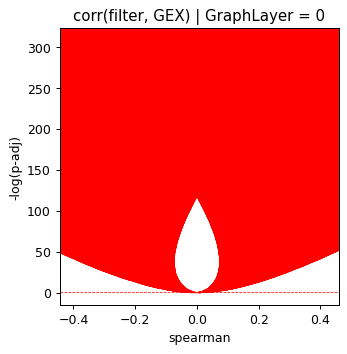

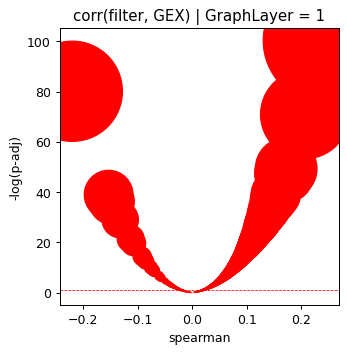

In [110]:
rcParams['figure.figsize'] = 4, 4
rcParams['figure.dpi'] = 90

for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 2), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('corr(filter, GEX) | GraphLayer = %i' % optimize_log_dynamic)
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

<Axes: xlabel='spearman', ylabel='Count'>

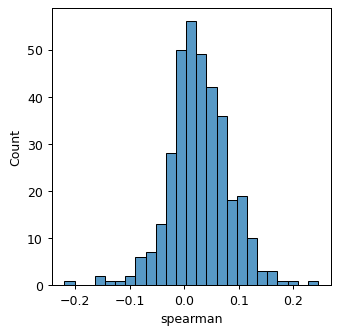

In [111]:
sns.histplot(grp['spearman'])

In [112]:
# sc.pl.umap(ad, color=[96], cmap='RdBu_r')
# sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

Text(0, 0.5, '# associations')

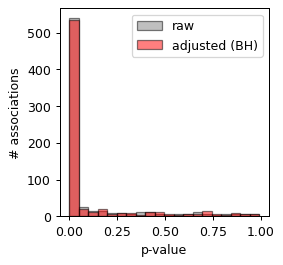

In [113]:
rcParams['figure.figsize'] = 3, 3
rcParams['figure.dpi'] = 90
plt.hist(res['p_val'], color='gray', bins=20, label='raw', alpha=.5, edgecolor = 'black')
plt.hist(res['p_adj'], color='red', bins=20, label='adjusted (BH)', alpha=.5, edgecolor = 'black')
plt.xlabel('p-value')
plt.legend()
plt.ylabel('# associations')

In [114]:
res[res['p_adj'] < 0.05]

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
0            0            False             1      Lhx6     True -0.087736   
1            1            False             2    Pou6f2     True -0.025458   
2            1            False             2      Lhx9     True -0.051279   
3            1            False             2      Emx2     True  0.417677   
4            1            False             2       Arx     True  0.442665   
..         ...              ...           ...       ...      ...       ...   
690        247             True           248     Arap2     True  0.032765   
691        248             True           249      Hsf2     True  0.045000   
693        261             True           262      Gli3     True  0.111026   
694        262             True           263    Tfap2c     True  0.064515   
695        263             True           264    Tfap2c     True  0.026947   

             p_val module_name          p_adj           k  
0     4.712331e-14        HD/1   1.186558e-13      Lhx6_1  
1     2.897336e-02        HD/2   3.855770e-02    Pou6f2_2  
2     1.076960e-05        HD/2   1.861412e-05      Lhx9_2  
3    1.202446e-308        HD/2  1.957471e-307      Emx2_2  
4     0.000000e+00        HD/2   0.000000e+00       Arx_2  
..             ...         ...            ...         ...  
690   4.939153e-03       NR/20   7.099398e-03   Arap2_248  
691   1.126444e-04         HSF   1.833745e-04    Hsf2_249  
693   1.269628e-21         GLI   3.847356e-21    Gli3_262  
694   3.037541e-08     TFAP2/2   6.075081e-08  Tfap2c_263  
695   2.079786e-02     TFAP2/1   2.805106e-02  Tfap2c_264  

[534 rows x 10 columns]

In [115]:
pval_thr = 1e-5
sel_genes = set(list(res[res['p_adj'] < pval_thr]['gene_name']))

In [116]:
log_act = ad.obsm['log_activities'].copy()

In [117]:
cols_act = ['intercept', 'dinuc_bias'] + [name_by_filter_id[k] for k in log_act.columns[2:]]
log_act.columns = cols_act

In [118]:
import anndata
ad_act = anndata.AnnData(log_act)
ad_act.obsm['X_umap'] = ad.obsm['X_umap']
ad_act.obs = ad.obs

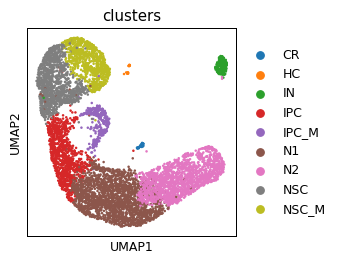

In [119]:
sc.pl.umap(ad_act, color=cell_type_key)


Rank genes groups using the annotation

In [120]:
sc.tl.rank_genes_groups(ad_act, cell_type_key)
rkg_df = []
for ct in ad_act.obs[cell_type_key].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2[cell_type_key] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df['module_name'] = rkg_df['names'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
rkg_df['module_name'] = np.where(~pd.isnull(rkg_df['module_name']), rkg_df['module_name'], rkg_df['names'])
rkg_df.head()

NSC_M
N1
IPC
NSC
IPC_M
N2
CR
HC
IN


names     scores  logfoldchanges         pvals     pvals_adj clusters  \
0  ZKSCAN1  21.499275             NaN  6.172890e-84  1.777792e-81    NSC_M   
1    OVOL1  21.026897             NaN  4.155369e-81  5.983731e-79    NSC_M   
2    SIX/2  20.639223             NaN  1.388494e-78  1.332954e-76    NSC_M   
3    ZNF28  20.028900             NaN  5.744338e-75  4.135924e-73    NSC_M   
4    POU/1  20.026346             NaN  1.253743e-74  5.512854e-73    NSC_M   

  module_name  
0     ZKSCAN1  
1       OVOL1  
2       SIX/2  
3       ZNF28  
4       POU/1

Get top modules

In [121]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index('names')['module_name'].to_dict())

In [122]:
sc.tl.rank_genes_groups(ad_act, cell_type_key)

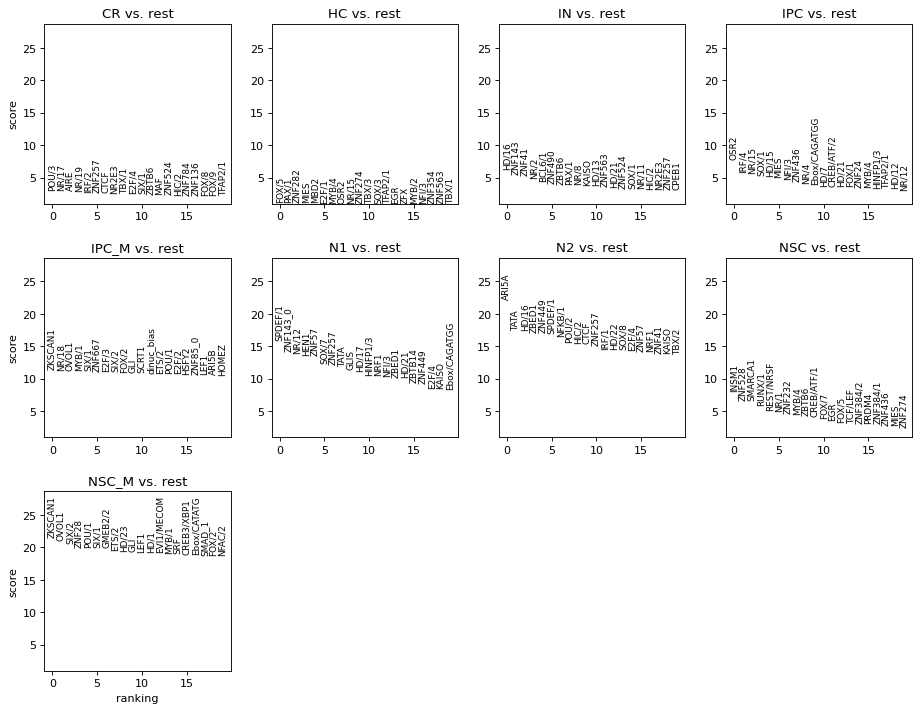

In [123]:
rcParams['figure.figsize'] = 3.5, 3.5
rcParams['figure.dpi'] = 80
sc.pl.rank_genes_groups(ad_act)


In [124]:
# set(res[(res['p_adj'] < 1e-5)]['k'])

In [125]:
res[res['module_name'].str.contains('HD')].sort_values('p_adj')

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
4            1            False             2       Arx     True  0.442665   
3            1            False             2      Emx2     True  0.417677   
14           7            False             8       Arx     True  0.338170   
25          24            False            25      Otx1     True  0.287126   
5            1            False             2      Lhx2     True  0.203768   
15          11            False            12      Pbx3     True  0.107847   
375         24             True            25      Otx1     True  0.095321   
12           6            False             7      Emx1     True -0.089355   
0            0            False             1      Lhx6     True -0.087736   
353          1             True             2      Emx2     True  0.086231   
364          7             True             8       Arx     True  0.084481   
358          1             True             2      Dlx2     True -0.076006   
9            1            False             2      Dlx1     True -0.075870   
8            1            False             2      Dlx2     True -0.075378   
13           6            False             7      Emx2     True -0.072867   
359          1             True             2      Dlx1     True -0.071776   
356          1             True             2      Lhx6     True -0.071258   
6            1            False             2      Lhx6     True -0.067680   
365         11             True            12      Pbx3     True  0.061053   
350          0             True             1      Lhx6     True -0.060752   
362          6             True             7      Emx1     True -0.058989   
361          1             True             2      Dlx5     True -0.057247   
2            1            False             2      Lhx9     True -0.051279   
360          1             True             2      Emx1     True -0.041471   
376         25             True            26      Otx1     True -0.039517   
354          1             True             2       Arx     True  0.034019   
11           1            False             2      Dlx5     True -0.029789   
1            1            False             2    Pou6f2     True -0.025458   
363          6             True             7      Emx2     True  0.024577   
10           1            False             2      Emx1     True -0.022922   
355          1             True             2      Lhx2     True  0.021151   
357          1             True             2     Lmx1a     True -0.020188   
352          1             True             2      Lhx9     True  0.006688   
26          25            False            26      Otx1     True  0.006461   
351          1             True             2    Pou6f2     True -0.002236   
7            1            False             2     Lmx1a     True -0.001761   

             p_val module_name          p_adj         k  
4     0.000000e+00        HD/2   0.000000e+00     Arx_2  
3    1.202446e-308        HD/2  1.957471e-307    Emx2_2  
14   2.673819e-196        HD/8  2.529289e-195     Arx_8  
25   1.145098e-139       HD/19  8.015689e-139   Otx1_25  
5     8.111656e-70        HD/2   3.785439e-69    Lhx2_2  
15    1.741761e-20       HD/12   5.101392e-20   Pbx3_12  
375   2.519745e-16       HD/19   6.706546e-16   Otx1_25  
12    1.599046e-14        HD/7   4.100117e-14    Emx1_7  
0     4.712331e-14        HD/1   1.186558e-13    Lhx6_1  
353   1.264470e-13        HD/2   3.138755e-13    Emx2_2  
364   3.901094e-13        HD/8   9.548132e-13     Arx_8  
358   6.644946e-11        HD/2   1.515134e-10    Dlx2_2  
9     7.185656e-11        HD/2   1.633104e-10    Dlx1_2  
8     9.521906e-11        HD/2   2.150108e-10    Dlx2_2  
13    3.896794e-10        HD/7   8.659543e-10    Emx2_7  
359   7.085803e-10        HD/2   1.554878e-09    Dlx1_2  
356   9.382253e-10        HD/2   2.033306e-09    Lhx6_2  
6     6.188324e-09        HD/2   1.277825e-08    Lhx6_2  
365   1.593298e-

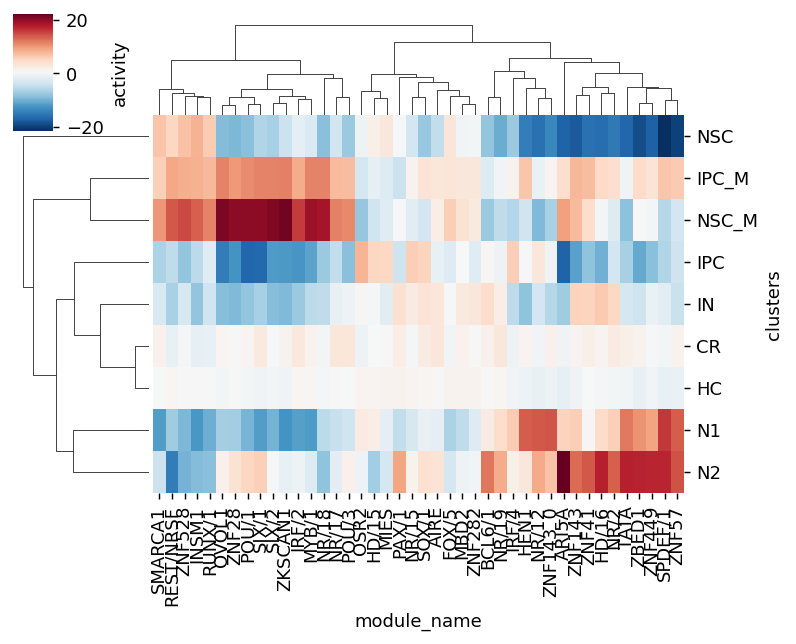

In [126]:
mod_names_best = set(rkg_df.sort_values('scores', ascending=False).groupby(cell_type_key).head(5)['module_name'])
best = rkg_df[rkg_df['module_name'].isin(mod_names_best)]
rcParams['figure.dpi'] = 130
sns.clustermap(best.pivot(index=cell_type_key, columns='module_name', values='scores'),
               cbar_kws={'label': 'activity'}, cmap='RdBu_r',
               # vmin=-5, vmax=5,
               figsize=[6.2, 5],
               # dpi=100,
               xticklabels=True)


In [127]:
rna_tfs = rna_sel.to_df()[list(set(res['gene_name']))]
rna_tfs[cell_type_key] = rna_sel.obs[cell_type_key]
mean_tfs = rna_tfs.groupby(cell_type_key).mean()

act_tfs_df = ad_act.to_df()
act_tfs_df[cell_type_key] = ad_act.obs[cell_type_key]
mean_act_tf = act_tfs_df.groupby(cell_type_key).mean()

In [128]:
corr_celltype = []
for i, c1 in enumerate(mean_act_tf):
    if i % 50 == 0:
        print(i, mean_act_tf.shape[1])
    for j, c2 in enumerate(mean_tfs):
        if not c1 in genes_by_module_name or not c2 in genes_by_module_name[c1]:
            continue
        a = mean_act_tf[c1]
        b = mean_tfs[c2]
        corr_celltype.append([c1, c2, mean_act_tf.index[np.argmax(mean_act_tf[c1])]] + list(pearsonr(a, b)))

corr = pd.DataFrame(corr_celltype,
                    columns=['module_name', 'gene_name', 'cell_type', 'pearsonr', 'p_val'])
corr = corr.sort_values('pearsonr', ascending=False)


0 288
50 288
100 288
150 288
200 288
250 288


In [129]:
# sc.pl.dotplot(rna_sel, groupby='celltype', var_names=list(set(res['gene_name'])))

In [130]:
corr[corr['pearsonr'] > 0].sort_values('p_val')

module_name gene_name cell_type  pearsonr     p_val
179         HIF     Epas1        HC  0.927976  0.000308
349       NFI/2      Nfia        CR  0.899426  0.000962
85        NR/20     Nr3c1        HC  0.883691  0.001574
123  CREB/ATF/2      Junb        HC  0.873790  0.002074
83        NR/20      Arsb        HC  0.852563  0.003497
..          ...       ...       ...       ...       ...
9      KLF/SP/2      Egr1     IPC_M  0.037409  0.923880
178       ETS/2      Ets1     IPC_M  0.029951  0.939031
274       TBX/1     Ttyh1        HC  0.021263  0.956700
198       FOX/5     Foxo1        HC  0.002574  0.994756
194        HD/2    Pou6f2     IPC_M  0.001198  0.997560

[178 rows x 5 columns]

repressors


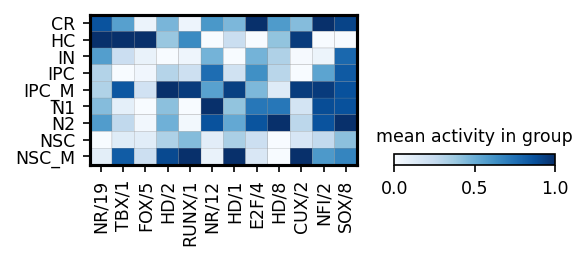

In [131]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 150

# repressors
print('repressors')

module_names = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.3],
            standard_scale='var',
            colorbar_title='mean activity in group')



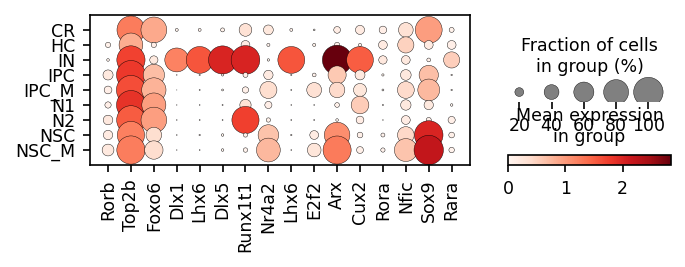

In [132]:
sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              # colorbar_title='mean GEX',
              var_names=gene_names,
              figsize=[5, 1.3])


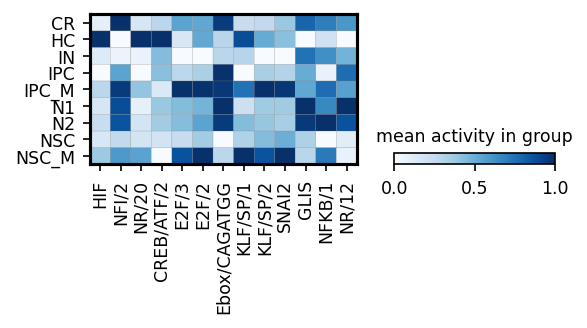

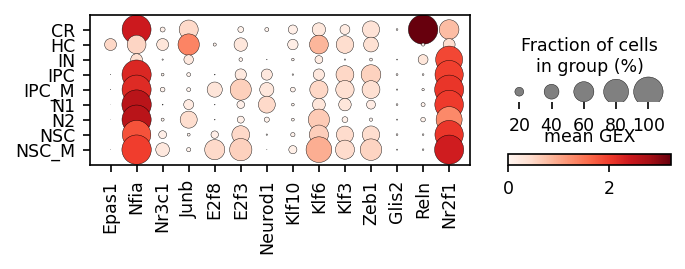

In [133]:
# activators
rcParams['pdf.fonttype'] = 42

module_names = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.3],
            show=False,
            standard_scale='var',
            colorbar_title='mean activity in group')

plt.savefig('../../../output/filter_activities_neurogenesis.pdf')
plt.show()


sc.pl.dotplot(rna_sel,
              show=False,
              groupby=cell_type_key,
              colorbar_title='mean GEX',
              var_names=gene_names,
              figsize=[5, 1.3])

plt.savefig('../../../output/gene_expression_neurogenesis.pdf')
plt.show()


In [134]:
filter_id_by_name = {v: k for k, v in zip(name_by_filter_id.keys(), name_by_filter_id.values())}

In [135]:
custom_names = pd.Series(['NFI/1', 'E2F/4', 'HD/2', 'GLI', 'HSF', 'POU/3', 'PAX/1', 'CUX/1', 'KLF/SP/2', 'NR/14', 'HD/19'])
# custom_names = pd.Series(['FOX/4',])
custom_names.map(res.set_index('module_name')['filter_id'].to_dict()),

(0     188
 1     157
 2       1
 3     261
 4     248
 5      82
 6     280
 7      13
 8     108
 9      42
 10     24
 dtype: int64,)

GLI


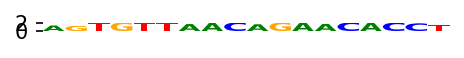

In [136]:
for k in list(anno.sort_values('Cluster_ID')['Name']):
    if k != 'GLI':
        continue
    print(k)
    mb.pl.logo(
        model,
        title=False,
        xticks=False,
        rowspan_dinuc=0,
        rowspan_mono=1,
        n_rows=40,
        log_odds=True,
        # stop_at=11,
        show=False,
        # n_rows=len(res.head(20).index),
        n_cols=1,
        order=pd.Series([k]).map(filter_id_by_name) + 2,
    )  # n_cols=len(reduced_groups))
    # plt.tight_layout()
    plt.show()

In [137]:
res.drop_duplicates('filter_id')

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
0            0            False             1      Lhx6     True -0.087736   
1            1            False             2    Pou6f2     True -0.025458   
12           6            False             7      Emx1     True -0.089355   
14           7            False             8       Arx     True  0.338170   
15          11            False            12      Pbx3     True  0.107847   
..         ...              ...           ...       ...      ...       ...   
343        261            False           262      Gli3     True  0.230897   
344        262            False           263    Tfap2c     True  0.189942   
345        263            False           264    Tfap2c     True -0.319823   
346        272            False           273      Zic4     True -0.008062   
349        280            False           281      Pax6     True -0.565214   

             p_val module_name          p_adj           k  
0     4.712331e-14        HD/1   1.186558e-13      Lhx6_1  
1     2.897336e-02        HD/2   3.855770e-02    Pou6f2_2  
12    1.599046e-14        HD/7   4.100117e-14      Emx1_7  
14   2.673819e-196        HD/8  2.529289e-195       Arx_8  
15    1.741761e-20       HD/12   5.101392e-20     Pbx3_12  
..             ...         ...            ...         ...  
343   1.198642e-89         GLI   6.261564e-89    Gli3_262  
344   9.700005e-61     TFAP2/2   4.297471e-60  Tfap2c_263  
345  1.201576e-174     TFAP2/1  1.051379e-173  Tfap2c_264  
346   4.892764e-01         ZIC   5.368236e-01    Zic4_273  
349   0.000000e+00       PAX/1   0.000000e+00    Pax6_281  

[99 rows x 10 columns]

0     188
1     157
2       1
3     261
4     248
5      82
6     280
7      13
8     108
9      42
10     24
dtype: int64


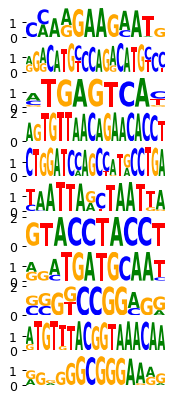

In [138]:
print(custom_names.map(res.set_index('module_name')['filter_id'].to_dict()))
mb.pl.set_rcParams({"figure.figsize": [2, 20], "figure.dpi": 90})
mb.pl.logo(
    model,
    title=False,
    xticks=False,
    rowspan_dinuc=0,
    rowspan_mono=1,
    n_rows=40,
    log_odds=True,
    # stop_at=11,
    show=False,
    # n_rows=len(res.head(20).index),
    n_cols=1,
    order=custom_names.map(filter_id_by_name) + 2,
)  # n_cols=len(reduced_groups))
# plt.tight_layout()

plt.savefig('../../../output/motif_neurogenes_publication.pdf')
plt.show()


0     91
1     39
2     51
3    104
dtype: int64


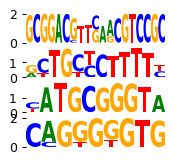

In [175]:
custom_names = pd.Series(['SOX/3', 'NR/11', 'CCAAT/CEBP', 'PRDM1'])

print(custom_names.map(res.set_index('module_name')['filter_id'].to_dict()))
mb.pl.set_rcParams({"figure.figsize": [2, 20], "figure.dpi": 90})
mb.pl.logo(
    model,
    title=False,
    xticks=False,
    rowspan_dinuc=0,
    rowspan_mono=1,
    n_rows=40,
    log_odds=True,
    # stop_at=11,
    show=False,
    # n_rows=len(res.head(20).index),
    n_cols=1,
    order=custom_names.map(filter_id_by_name) + 2,
)  # n_cols=len(reduced_groups))
# plt.tight_layout()

plt.savefig('../../../output/motif_pancreatic_endocrinogenesis_publication_subset.pdf')
plt.show()


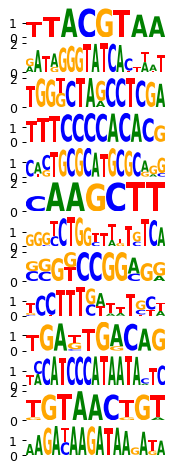

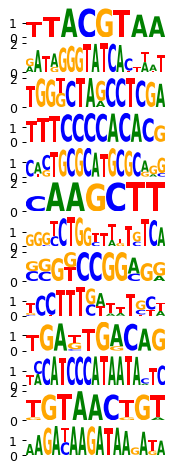

<Figure size 180x1800 with 0 Axes>

In [140]:
mb.pl.set_rcParams({"figure.figsize": [2, 20], "figure.dpi": 90})
mb.pl.logo(
    model,
    title=False,
    xticks=False,
    rowspan_dinuc=0,
    rowspan_mono=1,
    log_odds=True,
    n_rows=40,
    # stop_at=11,
    show=False,
    # n_rows=len(res.head(20).index),
    n_cols=1,
    # log_odds=True,
    order=module_names.map(res.set_index('module_name')['filter_id'].to_dict()),
)  # n_cols=len(reduced_groups))
# plt.tight_layout()

plt.show()
mb.pl.logo(
    model,
    title=False,
    xticks=False,
    rowspan_dinuc=0,
    rowspan_mono=1,
    n_rows=40,
    # stop_at=11,
    show=False,
    # n_rows=len(res.head(20).index),
    n_cols=1,
    log_odds=True,
    order=module_names.map(res.set_index('module_name')['filter_id'].to_dict()),
)  # n_cols=len(reduced_groups))
# plt.tight_layout()
plt.show()
# assert False

plt.savefig('../../../output/motif_neurogenesis.pdf')
plt.show()


In [141]:
!readlink -f ../../../output/motif_neurogenesis.pdf

/home/ilibarra/workspace/theislab/mubind/output/motif_neurogenesis.pdf


## Filter activities versus graph activities

In [142]:
A = model.get_log_activities()
sum_A = A.abs().sum(axis=1).cpu().detach().numpy()
A = A.squeeze(0)
print(A.shape)

torch.Size([288, 7359])


In [143]:
# this function assesses the contributions of A on the graph
indices, contributions, max_eig = mb.tl.compute_contributions(A.cpu(), C.cpu(), D.cpu())

contributions_normalized = torch.abs(contributions) / max_eig
contributions_df = pd.DataFrame(contributions_normalized.detach(), columns=['index'])
print("Summary statistics of the normalized contributions: \n")
contributions_df.describe()

Summary statistics of the normalized contributions: 



index
count  288.000000
mean     0.264926
std      0.065371
min      0.146912
25%      0.209978
50%      0.260296
75%      0.314351
max      0.413175

Percentage of non-zero entries of the filter matrix A: 100.0 %


<Figure size 1000x500 with 0 Axes>

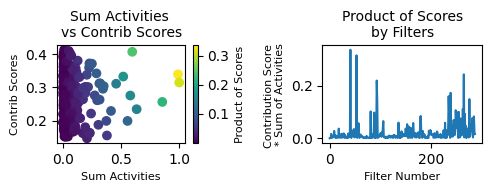

In [144]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 100
plt.figure(figsize=(10, 5))

print(f"Percentage of non-zero entries of the filter matrix A: {100 * torch.sum(A != 0).item() / A.numel()} %")
mb.pl.filter_contrib_simple(contributions_normalized, A.cpu())

In [145]:
# normalize the data, and look at summary stats
sum_A_norm = sum_A / np.max(sum_A)
sum_A_df = pd.DataFrame(sum_A.T, columns=['sum_A'])
sum_A_df.describe()

sum_A
count  288.000000
mean     0.746615
std      1.270342
min      0.000068
25%      0.119778
50%      0.301893
75%      0.753946
max      9.227266

In [146]:
contrib_arr = contributions_normalized.unsqueeze(dim=0).detach().numpy()
sum_A = A.cpu().abs().sum(axis=1).detach().numpy()
contrib = contrib_arr[0]

contrib_times_activities = contrib * sum_A
contrib_times_activities_norm = contrib_times_activities / np.max(contrib_times_activities)
contrib_times_activities_df = pd.DataFrame(contrib_times_activities, columns=['contribution_times_activities'])
contrib_times_activities_df.describe()

contribution_times_activities
count                     288.000000
mean                        0.202153
std                         0.379312
min                         0.000013
25%                         0.029517
50%                         0.080536
75%                         0.179532
max                         3.099209

In [147]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 80

# unsqueeze the data to make it compatible with the heatmap function
sum_A_norm = sum_A_norm.reshape(1,-1)
contrib_times_activities = contrib_times_activities.reshape(1,-1)


# # only plotting filters, that are within the top 25% of the maximum contribution score
# mb.pl.contrib_heatmaps(contributions_normalized,
#                        sum_A.reshape(1, -1),
#                        contrib_times_activities,
#                        cmap='Reds')
#                        # (0.66, 11.85, 6.49),
#                        # (0.66, 11.85, 6.49)) # vmin values come from the describe() functions

# # plotting top 25% of filters normalized
# mb.pl.contrib_heatmaps(contributions_normalized,
#                        sum_A_norm,
#                        contrib_times_activities_norm.reshape(1,-1),
#                        cmap='Reds')
#                        # vmins=(0.66, 0.14, 0.19),
#                        # centers=(0.66, 0.14, 0.19)) # vmin values come from the describe() functions

# # plotting all filter
# mb.pl.contrib_heatmaps(contributions_normalized,
#                        sum_A.reshape(1, -1),
#                        contrib_times_activities,
#                        cmap='Reds')

# # plotting all filters normalized
# mb.pl.contrib_heatmaps(contributions_normalized,
#                        sum_A_norm,
#                        contrib_times_activities,
#                        cmap='Reds')

In [148]:
res['graph_score'] = res['filter_id'].map({i : contrib_times_activities[0][i + 2] for i in range(len(contrib_times_activities[0]) - 2)})

In [149]:
# grnpedia associations
ttrust = pd.read_csv('https://www.grnpedia.org/trrust/data/trrust_rawdata.mouse.tsv',
                     sep='\t',
                     header=None)
ttrust.columns = ['tf', 'target', 'role', 'ref']
ttrust = ttrust.groupby(['tf', 'role']).size().reset_index().pivot(index='tf', columns='role', values=0).fillna(0)
ttrust['consensus'] = np.where((ttrust['Activation'] > 0) & (ttrust['Repression'] == 0), 'red',
                               np.where((ttrust['Repression'] > 0) & (ttrust['Activation'] == 0), 'blue', 'purple'))

In [150]:
# res_sel.sort_values('act_change')

In [151]:
print('here...')

here...


In [152]:
def delta_models(model_by_logdynamic, func='mean'):
    model = model_by_logdynamic[True]
    model = model_by_logdynamic[True]
    
    log_act1 = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    if func == 'expsum':
        log_act1 = log_act1.exp() / log_act1.exp().sum()
    log_act1 = pd.DataFrame(log_act1.detach().cpu().numpy())

    model = model_by_logdynamic[False]
    log_act2 = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    if func == 'expsum':
        log_act2 = log_act2.exp() / log_act2.exp().sum()
    log_act2 = pd.DataFrame(log_act2.detach().cpu().numpy())

    d = None
    if func == 'mean':
        d = log_act1.mean(axis=0) - log_act2.mean(axis=0)
        d = pd.DataFrame(d, columns=['delta'])
        d['graph_on'] = log_act1.mean(axis=0)
        d['graph_off'] = log_act2.mean(axis=0)
        return d
    elif func == 'abssum' or func == 'expsum':
        d = log_act1.abs().sum(axis=0) - log_act2.abs().sum(axis=0)
        d = pd.DataFrame(d, columns=['delta'])
        d['graph_on'] = log_act1.abs().sum(axis=0)
        d['graph_off'] = log_act2.abs().sum(axis=0)
        return d


In [153]:

# graph = True - graph = False
delta_model = delta_models(model_by_logdynamic, func='expsum')
delta_model
delta_model = delta_model[2:]
delta_model.index = range(len(delta_model))
delta_model.index += 1
delta_model.index = delta_model.index.map(name_by_filter_id)
delta_model
n_select = 20
top_delta = delta_model.sort_values('delta', ascending=False).reset_index()['index'][:n_select]
bar_df = delta_model.sort_values('delta', ascending=False).reset_index().melt(id_vars='index', value_vars=['graph_on', 'graph_off'])


Text(0.5, 0, 'graph_on')

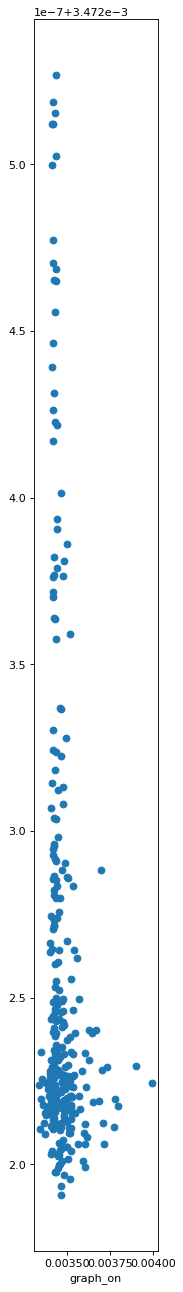

In [154]:
plt.scatter(delta_model['graph_off'], delta_model['graph_on'])
plt.xlabel('graph_off')
plt.xlabel('graph_on')

In [155]:
delta_model.sort_values('delta', ascending=False)

delta  graph_on  graph_off
TFAP2/1  0.000133  0.003472   0.003339
INSM1    0.000128  0.003472   0.003344
ZNF232   0.000121  0.003472   0.003351
GLI      0.000120  0.003472   0.003353
SOX/3    0.000118  0.003472   0.003355
...           ...       ...        ...
MECP2   -0.000300  0.003472   0.003773
HD/21   -0.000308  0.003472   0.003780
PRDM1   -0.000324  0.003472   0.003797
NFAT/3  -0.000428  0.003472   0.003900
BCL6/1  -0.000522  0.003472   0.003994

[286 rows x 3 columns]

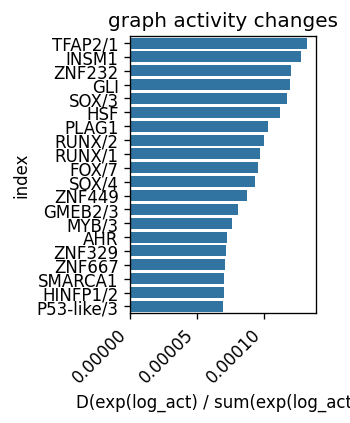

In [156]:
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = 2, 3
sns.barplot(data=delta_model.sort_values('delta', ascending=0).reset_index().head(20), x='delta', y='index')
plt.title('graph activity changes')
plt.xticks(rotation=45, ha='right')
plt.xlabel('D(exp(log_act) / sum(exp(log_act)))')
plt.savefig('../../../output/delta_log_act_exp_neurogenesis.pdf')
plt.show()

In [157]:
# if the delta organoid values are provided, then load and compare
delta_organoids = pd.read_csv('../../../output/delta_log_act_exp_organoids.csv', index_col=0)

delta_model['dataset'] = 'mouse_neurogenesis'
delta_organoids['dataset'] = 'human_organoids'

In [158]:
index_human = delta_organoids.sort_values('delta', ascending=0).reset_index().head(10)['index']
index_mouse = delta_model.sort_values('delta', ascending=0).reset_index().head(10)['index']



In [159]:
# delta_both.shape

In [160]:
order = delta_model.sort_values('delta', ascending=0).index
order_sel = set(order[order.isin(index_human) | order.isin(index_mouse)])
delta_both_all = pd.concat([delta_organoids, delta_model])
delta_both = pd.concat([delta_organoids.reindex(order_sel), delta_model.reindex(order_sel)])

0.15945890483794758 0.006888308954743277


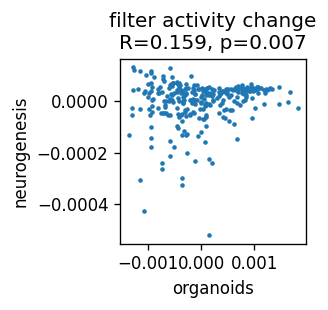

In [161]:
rcParams['figure.figsize'] = 2, 2
pivot_df = delta_both_all.reset_index().pivot(index='index', columns='dataset', values='delta')

from scipy import stats
corr_result = stats.pearsonr(pivot_df['human_organoids'], pivot_df['mouse_neurogenesis'])
print(corr_result.statistic, corr_result.pvalue)

pivot_df.shape

plt.scatter(pivot_df['human_organoids'], pivot_df['mouse_neurogenesis'], s=3)
plt.xlabel('organoids')
plt.ylabel('neurogenesis')
plt.title('filter activity change\nR=%.3f, p=%.3f' % (corr_result.statistic, corr_result.pvalue))
plt.savefig("../../../output/changes_organoids_and_neurogenesis.pdf")

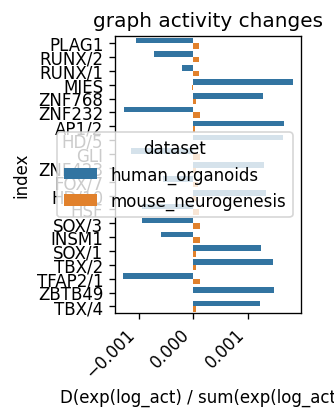

In [162]:
delta_model

rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = 2, 3
sns.barplot(data=delta_both[delta_both.index.isin(index_human) | delta_both.index.isin(index_mouse)].reset_index(), x='delta', y='index', hue='dataset')
plt.title('graph activity changes')
plt.xticks(rotation=45, ha='right')
plt.xlabel('D(exp(log_act) / sum(exp(log_act)))')
# plt.savefig('../../../output/delta_log_act_exp_neurogenesis.pdf')
plt.show()

<Axes: xlabel='value', ylabel='index'>

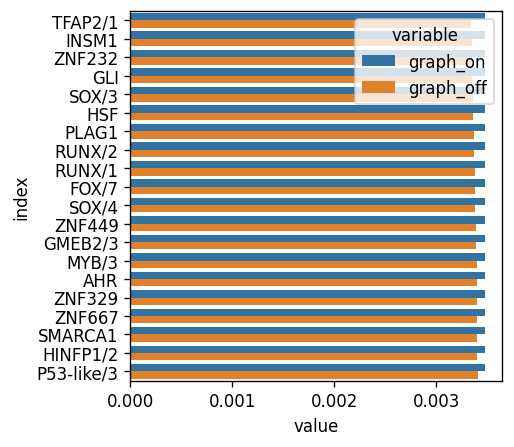

In [163]:
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = 4, 4
sns.barplot(data=bar_df[bar_df['index'].isin(top_delta)], y='index', x='value', hue='variable')

In [164]:
rcParams['figure.figsize'] = 3, 3
rcParams['figure.dpi'] = 250
rcParams['pdf.fonttype'] = 42

from adjustText import adjust_text

res['act_change'] = res['module_name'].map(delta_model['delta'].to_dict())
res['k'] = res['module_name'] + ':' + res['gene_name']
res['graph_score'] = res['filter_id'].map({i : contrib_times_activities[0][i + 2] for i in range(len(contrib_times_activities[0]) - 2)})
res['z'] = np.sqrt((res['graph_score'] ** 2) * (-np.log(res['p_adj'] + 1e-10)) ** 2)


SOX/4:Sox9 (2.6940284748144043e-05, -0.21938014712945927) 9.35655552893877e-05
PRDM1:Prdm16 (1.7878811798104274e-05, -0.0917151767367197) -0.0003243109676986933
GLI:Gli3 (1.3551140259722075e-05, 0.11102551480230653) 0.0001196127850562334
SOX/3:Sox9 (1.0259301609975559e-05, 0.04313964387916473) 0.00011771381832659245
TFAP2/1:Tfap2c (8.012593530772662e-06, 0.026946638604905353) 0.00013288320042192936
FOX/7:Foxo6 (6.919009080482413e-06, 0.13544323504533537) 9.542983025312424e-05
FOX/5:Foxo1 (6.210382466767795e-06, 0.036868129675778) -0.00017945002764463425
FOX/5:Foxg1 (4.44730826936683e-06, 0.026401584582038062) -0.00017945002764463425
PROX1:Prox1 (3.524228383859824e-06, -0.0336303518997785) 6.584427319467068e-05
HSF:Hsf2 (3.455791458989058e-06, 0.04499997110184604) 0.00011199456639587879
CCAAT/CEBP:Nfil3 (3.290349327573295e-06, 0.10397394464617533) 1.0900432243943214e-05
NFI/2:Nfia (3.0298595178163996e-06, 0.20648198706902032) -0.00023232167586684227
FOX/5:Foxp2 (2.5312771524808906e-06, 

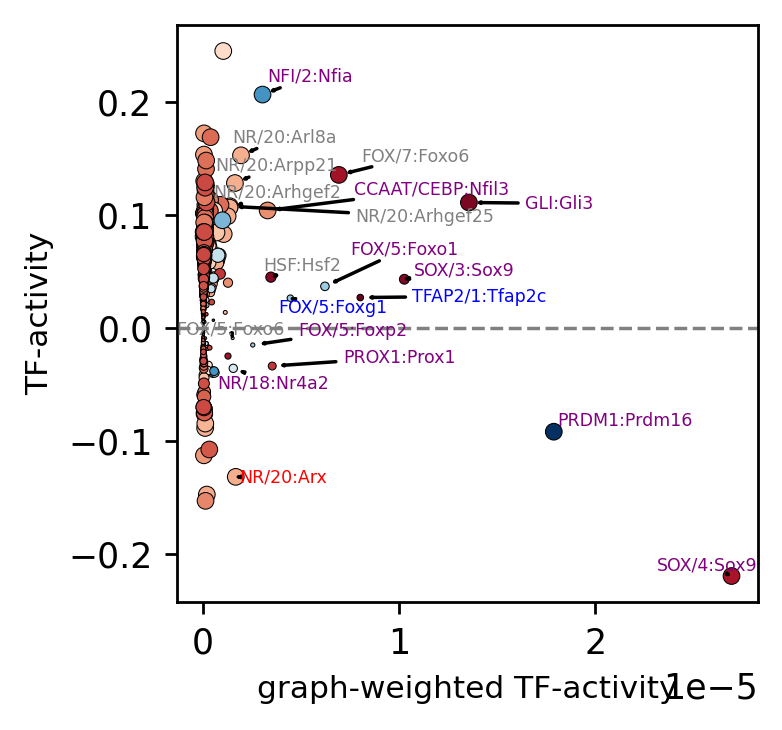

In [165]:


ax = plt.subplot()
cmap = sns.color_palette('RdBu_r', as_cmap=True)

res = res[res['opt_log_dynamic']]

res_sel = res.sort_values('z', ascending=False)
res_sel = res_sel.sort_values('z', ascending=False) # .drop_duplicates('module_name')
# res_sel = res_sel.drop_duplicates('module_name')

# res_sel['x'] = np.log((res_sel['graph_score'] + 1) * (res_sel['act_change'].abs() + 1))
res_sel['x'] = res_sel['graph_score'] * res_sel['act_change'].abs() * res_sel['spearman'].abs()

edgecolors = res_sel['gene_name'].map(ttrust['consensus'].to_dict())
edgecolors = np.where(~pd.isnull(edgecolors), edgecolors, 'gray')
res_sel['edgecolors'] = edgecolors
plt.scatter(res_sel['x'],            
            res_sel['spearman'],
            s=-np.log(res_sel['p_adj'] + 1e-10),
            cmap=cmap,
            lw=.3,
            edgecolors='black', # res_sel['edgecolors'],
            c=res_sel['act_change'])
plt.axhline(y=0, ls='--', c='gray', lw=1.0)
plt.xlabel('graph-weighted TF-activity', fontsize=9) # G_layer * abs(act) * abs(rho(GEX, act))'
plt.ylabel('TF-activity', fontsize=9) # rho(GEX, act)


res_sel = res_sel.sort_values('x', ascending=False) # .drop_duplicates('module_name')
texts = [] # [plt.text(x[i], y[i], 'Text%s' %i, ha='center', va='center') for i in range(len(x))]

for ri, r in res_sel.head(20).iterrows():
    print(r['module_name'] + ':' + r['gene_name'], (r['x'], r['spearman']), r['act_change'])
    t = ax.annotate(r['module_name'] + ':' + r['gene_name'], (r['x'], r['spearman']), fontsize=5, color=r['edgecolors'])
    texts.append(t)
adjust_text(texts, arrowprops=dict(arrowstyle='->'))

plt.savefig('../../../output/graph_contribution_neurogenesis.pdf')
plt.show()

In [166]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

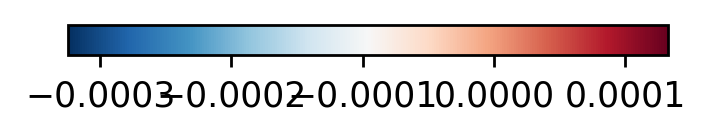

In [167]:
import pylab as pl
import numpy as np

a = np.array([[res_sel['act_change'].min(), res_sel['act_change'].max()]])
pl.figure(figsize=(3, .2))
img = pl.imshow(a, cmap="RdBu_r")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)
pl.savefig("../../../output/graph_contribution_neurogenesis_cbar.pdf")

In [168]:
!readlink -f ../../../output/graph_contribution_neurogenesis.pdf

/home/ilibarra/workspace/theislab/mubind/output/graph_contribution_neurogenesis.pdf


In [169]:
print('here...')

here...


In [170]:
def running_mean(y_in, x_in, N_out=101, sigma=.05):
    '''
    Returns running mean as a Bell-curve weighted average at evenly spaced
    points. Does NOT wrap signal around, or pad with zeros.
    
    Arguments:
    y_in -- y values, the values to be smoothed and re-sampled
    x_in -- x values for array
    
    Keyword arguments:
    N_out -- NoOf elements in resampled array.
    sigma -- 'Width' of Bell-curve in units of param x .
    '''
    import numpy as np
    N_in = len(y_in)

    # Gaussian kernel
    x_out = np.linspace(np.min(x_in), np.max(x_in), N_out)
    x_in_mesh, x_out_mesh = np.meshgrid(x_in, x_out)
    gauss_kernel = np.exp(-np.square(x_in_mesh - x_out_mesh) / (2 * sigma**2))
    # Normalize kernel, such that the sum is one along axis 1
    normalization = np.tile(np.reshape(np.sum(gauss_kernel, axis=1), (N_out, 1)), (1, N_in))
    gauss_kernel_normalized = gauss_kernel / normalization
    # Perform running average as a linear operation
    y_out = gauss_kernel_normalized @ y_in

    return y_out, x_out

In [171]:
def plot_chromatin(filter_name, sigma_chrom,
                   group_key=None, key_sel=None,
                   q_thr=.95, show=True, save=None):
    res_sel = res[res['module_name'].str.contains(filter_name)]['filter_id']
    if res_sel.shape[0] == 0:
        print('not found')
        return None
    filter_id = int(res_sel.values[0])
    print(filter_id)
    scores = binding_per_mode[:,filter_id]
    # filter scores across regions
    # plt.hist(scores)

    if group_key is not None and key_sel is not None:
        ad_sel = ad[ad.obs[group_key] == key_sel]
    else:
        ad_sel = ad
    print('here')

    var_idx = np.argwhere(scores >= np.quantile(scores, q_thr)).flatten()
    var_names = ad_sel.var_names[var_idx]
    print(q_thr, var_names.shape)
    # background with all peaks
    var_names_neg = ad_sel.var_names[~ad.var_names.isin(var_names)]
    
    x = ad_sel.obs['velocity_pseudotime']
    y = ad_sel[:,var_names].X.mean(axis=1).A.flatten()
    # y = np.log(y)
    # y[y == -np.inf] = np.nanmin(y[y != -np.inf])
    y_mean, x_mean = running_mean(y, x, sigma=sigma_chrom)
    plt.scatter(x, y, edgecolors=None, color='lightblue', s=.1)
    plt.plot(x_mean, y_mean, color='blue', label='targets')
    plt.ylabel('')
    plt.title(filter_name + ((', %s' % key_sel) if key_sel is not None else ''))
    plt.ylabel('chromatin accessibility [mean]')
    plt.xlabel('pseudotime')
    # plt.show()

    print(q_thr, var_names_neg.shape)
    x = ad_sel.obs['velocity_pseudotime']
    y = ad_sel[:,var_names_neg].X.mean(axis=1).A.flatten()
    # y = np.log(y)
    # y[y == -np.inf] = np.nanmin(y[y != -np.inf])
    y_mean_avr, x_mean = running_mean(y, x, sigma=sigma_chrom)
    # plt.scatter(x, y, edgecolors=None, color='lightblue', s=.1)
    plt.plot(x_mean, y_mean_avr, color='gray', linestyle='--', label='non-targets')
    plt.ylabel('')
    plt.ylabel('chromatin accessibility [mean]')
    plt.xlabel('pseudotime')
    plt.legend()

    if save is not None:
        plt.savefig(save + '_filter.pdf')
    if not show:
        plt.close()
    else:
        plt.show()
    return (y_mean - y_mean_avr).sum()

def plot_pseudotime(rna, gene_name, filter_name, sigma_gex=.05, sigma_filter=.1, save=None):
    rcParams['figure.figsize'] = 3, 2
    gene_key = gene_name
    x = rna.obs['velocity_pseudotime']
    y = rna[:,rna.var_names==gene_key].X.A.flatten()
    y = np.log(y)
    y[y == -np.inf] = np.nanmin(y[y != -np.inf])

    y_mean, x_mean = running_mean(y, x, sigma=sigma_gex)
    plt.scatter(x, y, edgecolors=None, color='lightgreen', s=.1)
    plt.plot(x_mean, y_mean, color='green')
    plt.ylabel('')
    plt.title(gene_key)
    plt.ylabel('gene expression [log]')
    plt.xlabel('pseudotime')


    x = ad.obs['velocity_pseudotime']

    if save is not None:
        plt.savefig(save + '_gex.pdf')
    plt.show()
    filter_id = int(res[res['module_name'].str.contains(filter_name)]['filter_id'].values[0])

    y= act_on.T.numpy()[:,filter_id]
    # y = np.abs(y)
    # y = np.log(y)
    # y[y == -np.inf] = np.nanmin(y[y != -np.inf])

    y_mean, x_mean = running_mean(y, x, sigma=sigma_filter)
    # plt.scatter(x, y, edgecolors='black', color='lightgreen', s=.1)
    plt.plot(x_mean, y_mean, color='red')
    plt.ylabel('')
    plt.title('filter activities %s' % filter_name)
    plt.ylabel('filter activity')
    plt.xlabel('pseudotime')

    if save is not None:
        plt.savefig(save + '_filter.pdf')

    # plt.close()
    plt.show()



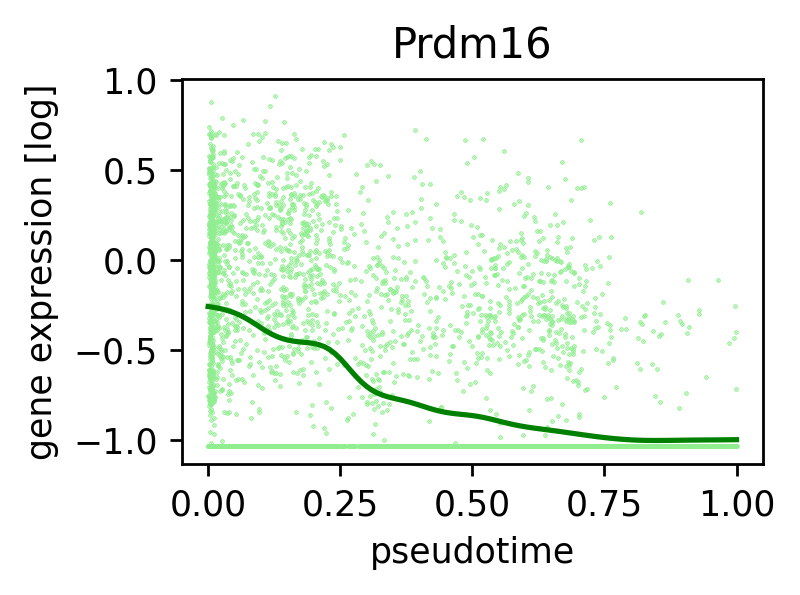

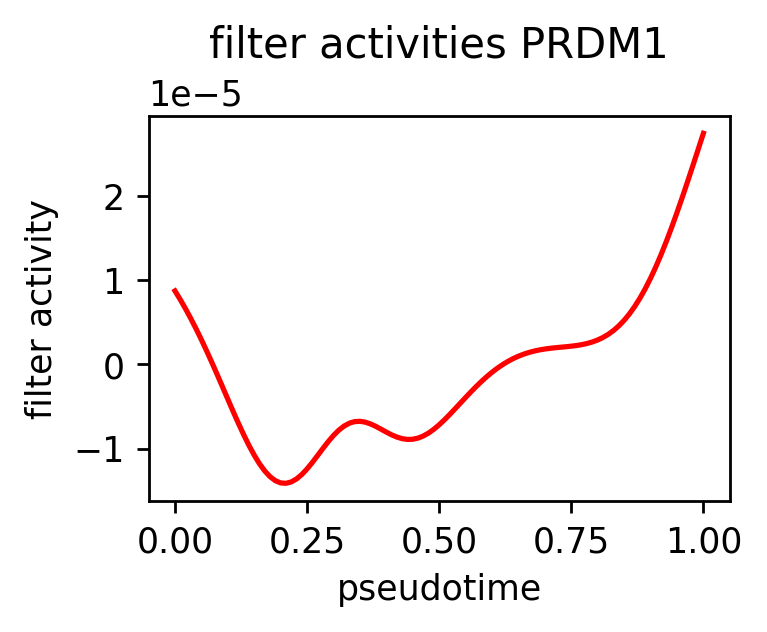

In [172]:
plot_pseudotime(rna_sample, 'Prdm16', 'PRDM1', sigma_gex=.05, sigma_filter=.1, save='../../../output/neurogenesis_prdm1')

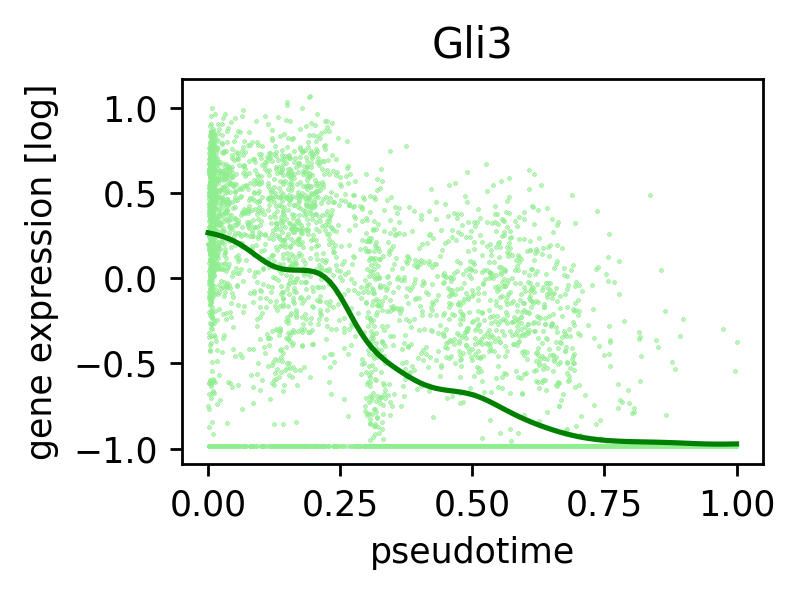

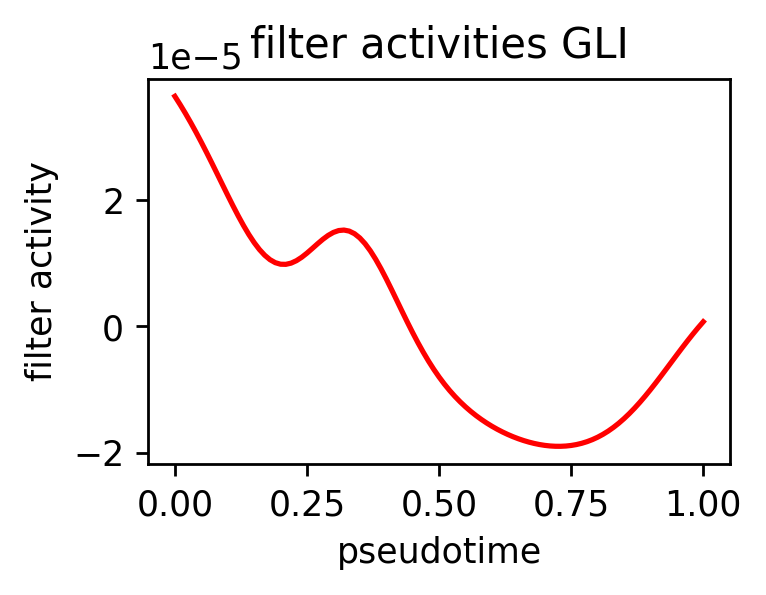

In [173]:
plot_pseudotime(rna_sample, 'Gli3', 'GLI', sigma_gex=.05, sigma_filter=.1, save='../../../output/neurogenesis_gli3')

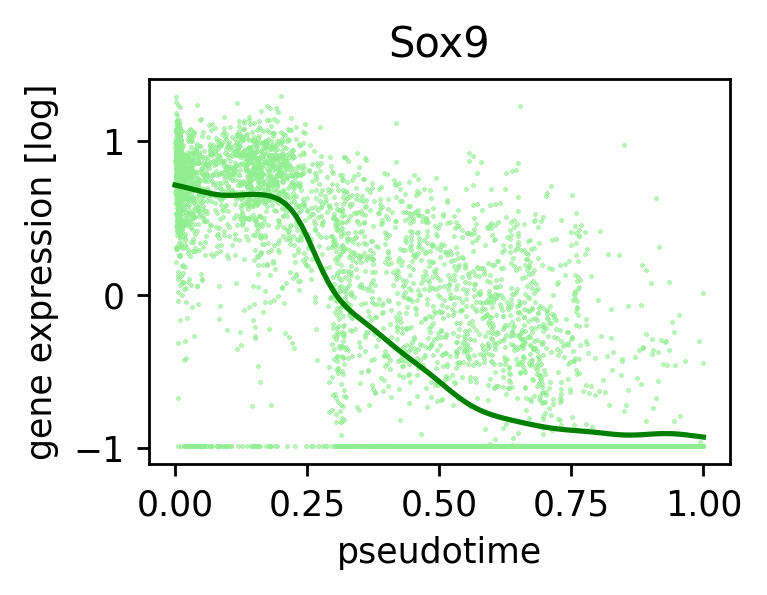

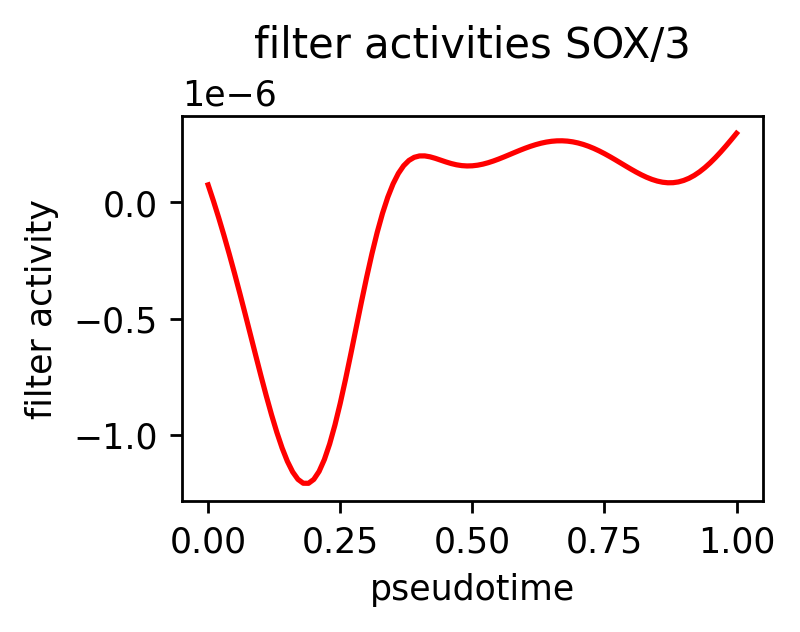

In [174]:
plot_pseudotime(rna_sample, 'Sox9', 'SOX/3', sigma_gex=.05, sigma_filter=.1, save='../../../output/neurogenesis_sox9')

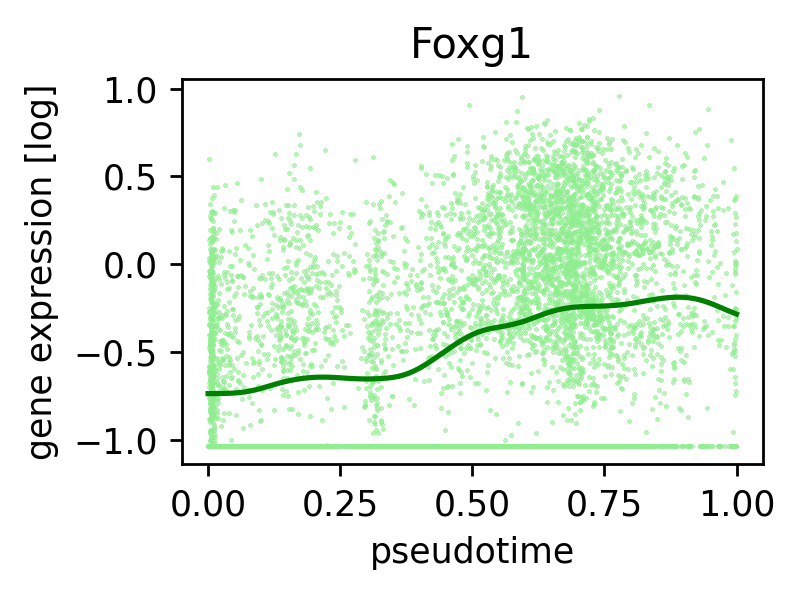

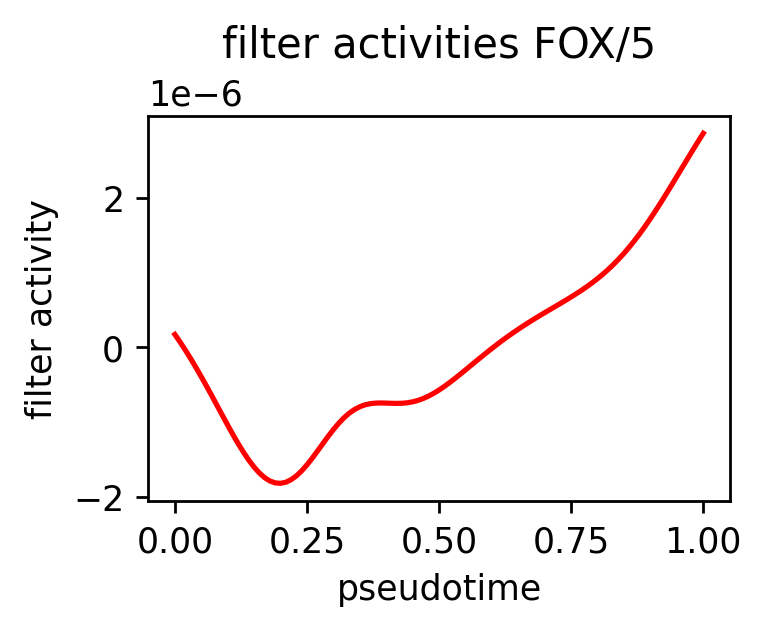

In [179]:
plot_pseudotime(rna_sample, 'Foxg1', 'FOX/5', sigma_gex=.05, sigma_filter=.1, save='../../../output/neurogenesis_foxg1')

In [ ]:
plot_pseudotime(rna_sample, 'Foxo6', 'FOX/5', sigma_gex=.05, sigma_filter=.1)

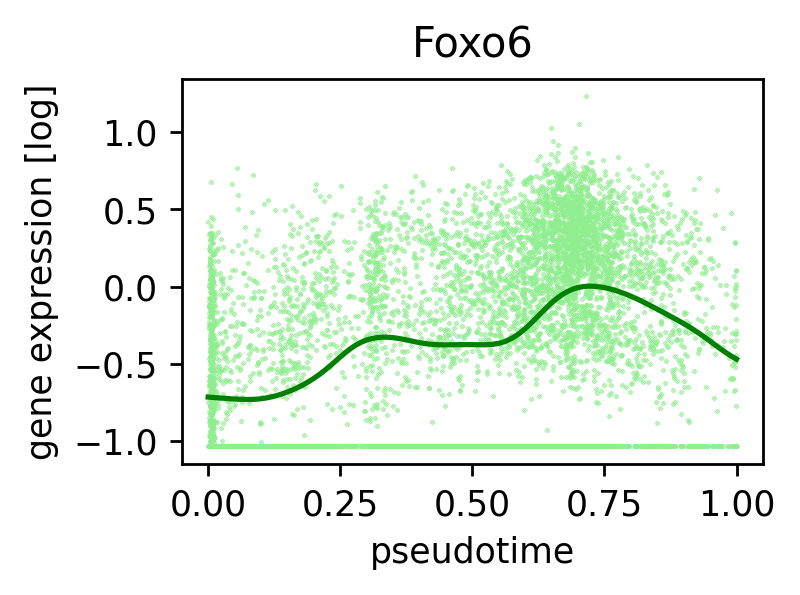

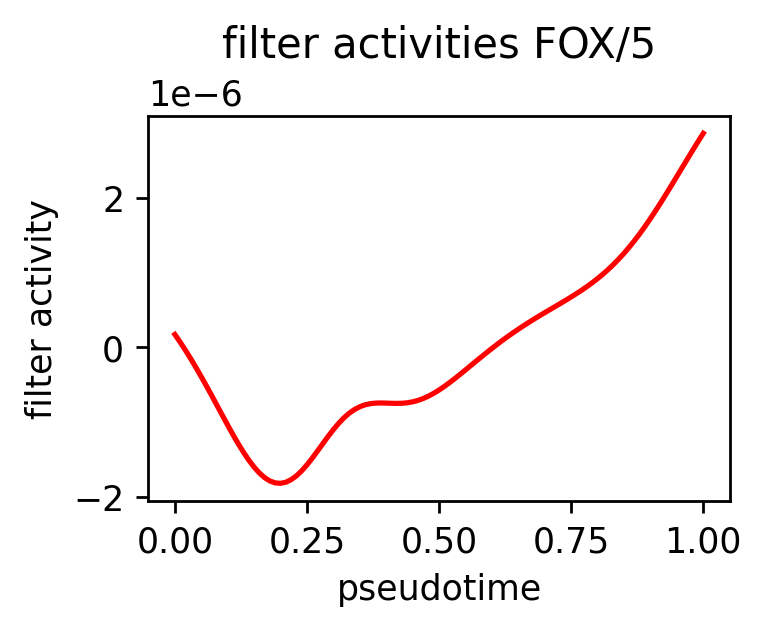

In [180]:
plot_pseudotime(rna_sample, 'Foxo6', 'FOX/5', sigma_gex=.05, sigma_filter=.1)

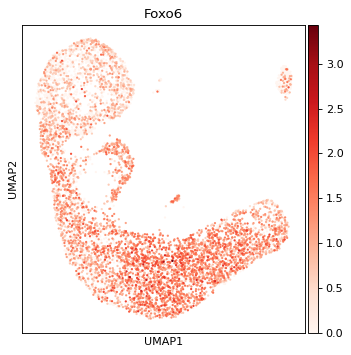

In [181]:
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 80
sc.pl.umap(rna_sample, color=['Foxo6'], cmap='Reds') #  'Nfil3', 'Arl8a', 'Rara', 'Tfap2c', 'Sox9', 'Qsox1', cell_type_key])


In [182]:
print('here...')

here...


In [183]:
# debug here almost done.

tsum = torch.sum
texp = torch.exp
tspa = torch.sparse_coo_tensor
tsmm = torch.sparse.mm
t = torch.transpose

log_dynamic = model.graph_module.log_dynamic
D = model.graph_module.log_dynamic
D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
D = D_tril + t(D_triu, 0, 1)
# log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
D

tensor(indices=tensor([[   0,    0,    0,  ..., 6906, 6980, 7289],
                       [   1,  251,  289,  ..., 7358, 7358, 7358]]),
       values=tensor([ 0.13,  0.51,  0.50,  ..., -0.50, -0.50, -0.50]),
       device='cuda:0', size=(7359, 7359), nnz=280548, layout=torch.sparse_coo,
       grad_fn=<AddBackward0>)

In [184]:
ad.layers['velocity'] = torch.stack([D.detach().cpu().to_dense().sum(axis=1),] * ad.shape[1], axis=1).numpy()
ad.layers['counts'] = ad.X

In [185]:
# with the new velocity graph based on learned weights, calculate the 
scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')


computing velocity graph (using 1/20 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ../../../output/neurogenesis_graph_layer.svg


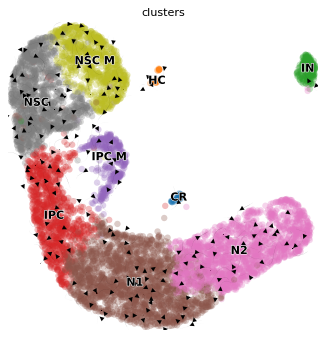

In [186]:
rcParams['figure.figsize'] = 5, 5,
scv.pl.velocity_embedding_stream(ad,
                                 legend_fontsize=10,
                                 color=cell_type_key,
                                 linewidth=.1,
                                 save="../../../output/neurogenesis_graph_layer.svg")

AttributeError: PathCollection.set() got an unexpected keyword argument 'edge_colors'

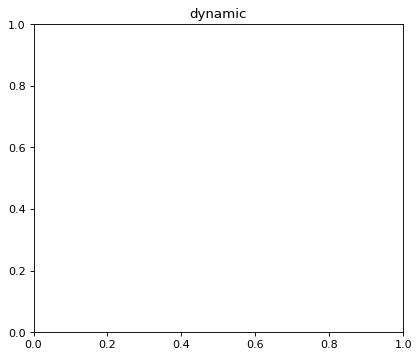

In [187]:
sc.pl.embedding_density(ad[ad.obs_names[:3]], basis='umap', key='umap_density_dynamic_score_z1', group='dynamic', color_map='viridis', edge_colors='black')
                        # save="dynamic_scores_neurogenesis.pdf") # basis='umap', groupby='dynamic_score_cluster')


In [ ]:
print('here...')

: 

In [ ]:
# test custom edge colors
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic', color_map='viridis', edge_colors='black')
                        # save="dynamic_scores_neurogenesis.pdf") # basis='umap', groupby='dynamic_score_cluster')


: 

In [ ]:
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 80
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic', color_map='viridis',
                        save="dynamic_scores_neurogenesis.pdf") # basis='umap', groupby='dynamic_score_cluster')
# plt.savefig(

: 

In [ ]:
!readlink -f figures/dynamic_scores_neurogenesis.pdf

: 

In [ ]:
rcParams['pdf.fonttype'] = 42
sc.pl.umap(rna_sample, color=cell_type_key, show=False)
plt.savefig("../../../output/annotation_neurogenesis.pdf")

: 

In [ ]:
rcParams['pdf.fonttype'] = 42
scv.pl.velocity_embedding_stream(rna_sample, color=cell_type_key, save="../../../output/velocity_stream_neurogenesis")

: 